# Predictive Maintenance (RUL Estimation)

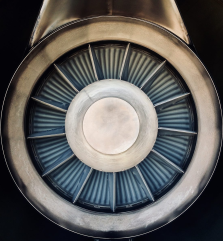

Dataset

- NASA's turbofan engine degradation dataset (CMAPSS).
- 4 datasets are available of increasing complexity. Data set FD001 is the first in the series and the least complex. We will focus on this one for our experiments.

All datasets can be accessed via link https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

- The aim of this notebook is to predict RUL (Remaining Useful Life of Engine) by applying various ML/deep learning models

The dataset contains:

Train trjectories: 100 engines.
Test trajectories: 100  engines.
Fault Modes: ONE (only one mode)

- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:

  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.

First, import the dataset into the workspace (3 files: train_FD001.txt, test_FD001.txt, RUL_FD001.txt).

1. train_FD001.txt -> train data **without** RUL (to compute);
2. test_FD001.txt -> test data **witout** RUL;
3. RUL_FD001.txt -> RUL for test data.

We will analyze the dataset using Pandas library.

**Note that the RUL for the training data must be computed from the provided data.**


## GOAL
Your task consists in creating two networks:
1. A feed-forward neural network;
2. A neural network composed by RNNs and linear layers.

You can use an arbitrary number of layers and dimensions (num. of neurons, num. of hidden cells, etc.).

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Importing the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL/train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL/test_FD001.txt',sep='\s+', header=None, names=col_names)
RUL_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

1. Train data contains all features (Unit Number + setting parameters & sensor parameters)
2. Test data contains all features (Unit Number + setting parameters & sensor parameters)
3. Y_test contains RUL for the test data.

In [4]:
train

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1            1            2     0.0019    -0.0003      100.0  518.67  642.15   
2            1            3    -0.0043     0.0003      100.0  518.67  642.35   
3            1            4     0.0007     0.0000      100.0  518.67  642.35   
4            1            5    -0.0019    -0.0002      100.0  518.67  642.37   
...        ...          ...        ...        ...        ...     ...     ...   
20626      100          196    -0.0004    -0.0003      100.0  518.67  643.49   
20627      100          197    -0.0016    -0.0005      100.0  518.67  643.54   
20628      100          198     0.0004     0.0000      100.0  518.67  643.42   
20629      100          199    -0.0011     0.0003      100.0  518.67  643.23   
20630      100          200    -0.0032    -0.0005      100.0  518.67  643.85   

           s_3      s_4    s_5    s_6     s_7      s_8      s_9  s_10   s_11  \
0      1589.70  1400.60  14.62  21.61  554.36  2388.06  9046.19   1.3  47.47   
1      1591.82  1403.14  14.62  21.61  553.75  2388.04  9044.07   1.3  47.49   
2      1587.99  1404.20  14.62  21.61  554.26  2388.08  9052.94   1.3  47.27   
3      1582.79  1401.87  14.62  21.61  554.45  2388.11  9049.48   1.3  47.13   
4      1582.85  1406.22  14.62  21.61  554.00  2388.06  9055.15   1.3  47.28   
...        ...      ...    ...    ...     ...      ...      ...   ...    ...   
20626  1597.98  1428.63  14.62  21.61  551.43  2388.19  9065.52   1.3  48.07   
20627  1604.50  1433.58  14.62  21.61  550.86  2388.23  9065.11   1.3  48.04   
20628  1602.46  1428.18  14.62  21.61  550.94  2388.24  9065.90   1.3  48.09   
20629  1605.26  1426.53  14.62  21.61  550.68  2388.25  9073.72   1.3  48.39   
20630  1600.38  1432.14  14.62  21.61  550.79  2388.26  9061.48   1.3  48.20   

         s_12     s_13     s_14    s_15  s_16  s_17  s_18   s_19   s_20  \
0      521.66  2388.02  8138.62  8.4195  0.03   392  2388  100.0  39.06   
1      522.28  2388.07  8131.49  8.4318  0.03   392  2388  100.0  39.00   
2      522.42  2388.03  8133.23  8.4178  0.03   390  2388  100.0  38.95   
3      522.86  2388.08  8133.83  8.3682  0.03   392  2388  100.0  38.88   
4      522.19  2388.04  8133.80  8.4294  0.03   393  2388  100.0  38.90   
...       ...      ...      ...     ...   ...   ...   ...    ...    ...   
20626  519.49  2388.26  8137.60  8.4956  0.03   397  2388  100.0  38.49   
20627  519.68  2388.22  8136.50  8.5139  0.03   395  2388  100.0  38.30   
20628  520.01  2388.24  8141.05  8.5646  0.03   398  2388  100.0  38.44   
20629  519.67  2388.23  8139.29  8.5389  0.03   395  2388  100.0  38.29   
20630  519.30  2388.26  8137.33  8.5036  0.03   396  2388  100.0  38.37   

          s_21  
0      23.4190  
1      23.4236  
2      23.3442  
3      23.3739  
4      23.4044  
...        ...  
20626  22.9735  
20627  23.1594  
20628  22.9333  
20629  23.0640  
20630  23.0522  

[20631 rows x 26 columns]

In [5]:
test

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1     0.0023     0.0003      100.0  518.67  643.02   
1            1            2    -0.0027    -0.0003      100.0  518.67  641.71   
2            1            3     0.0003     0.0001      100.0  518.67  642.46   
3            1            4     0.0042     0.0000      100.0  518.67  642.44   
4            1            5     0.0014     0.0000      100.0  518.67  642.51   
...        ...          ...        ...        ...        ...     ...     ...   
13091      100          194     0.0049     0.0000      100.0  518.67  643.24   
13092      100          195    -0.0011    -0.0001      100.0  518.67  643.22   
13093      100          196    -0.0006    -0.0003      100.0  518.67  643.44   
13094      100          197    -0.0038     0.0001      100.0  518.67  643.26   
13095      100          198     0.0013     0.0003      100.0  518.67  642.95   

           s_3      s_4    s_5    s_6     s_7      s_8      s_9  s_10   s_11  \
0      1585.29  1398.21  14.62  21.61  553.90  2388.04  9050.17   1.3  47.20   
1      1588.45  1395.42  14.62  21.61  554.85  2388.01  9054.42   1.3  47.50   
2      1586.94  1401.34  14.62  21.61  554.11  2388.05  9056.96   1.3  47.50   
3      1584.12  1406.42  14.62  21.61  554.07  2388.03  9045.29   1.3  47.28   
4      1587.19  1401.92  14.62  21.61  554.16  2388.01  9044.55   1.3  47.31   
...        ...      ...    ...    ...     ...      ...      ...   ...    ...   
13091  1599.45  1415.79  14.62  21.61  553.41  2388.02  9142.37   1.3  47.69   
13092  1595.69  1422.05  14.62  21.61  553.22  2388.05  9140.68   1.3  47.60   
13093  1593.15  1406.82  14.62  21.61  553.04  2388.11  9146.81   1.3  47.57   
13094  1594.99  1419.36  14.62  21.61  553.37  2388.07  9148.85   1.3  47.61   
13095  1601.62  1424.99  14.62  21.61  552.48  2388.06  9155.03   1.3  47.80   

         s_12     s_13     s_14    s_15  s_16  s_17  s_18   s_19   s_20  \
0      521.72  2388.03  8125.55  8.4052  0.03   392  2388  100.0  38.86   
1      522.16  2388.06  8139.62  8.3803  0.03   393  2388  100.0  39.02   
2      521.97  2388.03  8130.10  8.4441  0.03   393  2388  100.0  39.08   
3      521.38  2388.05  8132.90  8.3917  0.03   391  2388  100.0  39.00   
4      522.15  2388.03  8129.54  8.4031  0.03   390  2388  100.0  38.99   
...       ...      ...      ...     ...   ...   ...   ...    ...    ...   
13091  520.69  2388.00  8213.28  8.4715  0.03   394  2388  100.0  38.65   
13092  521.05  2388.09  8210.85  8.4512  0.03   395  2388  100.0  38.57   
13093  521.18  2388.04  8217.24  8.4569  0.03   395  2388  100.0  38.62   
13094  521.33  2388.08  8220.48  8.4711  0.03   395  2388  100.0  38.66   
13095  521.07  2388.05  8214.64  8.4903  0.03   396  2388  100.0  38.70   

          s_21  
0      23.3735  
1      23.3916  
2      23.4166  
3      23.3737  
4      23.4130  
...        ...  
13091  23.1974  
13092  23.2771  
13093  23.2051  
13094  23.2699  
13095  23.1855  

[13096 rows x 26 columns]

In [6]:
RUL_test

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [7]:
train['unit_nr'].unique()

# There are 100 unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Note:  RUL_001.txt contains true RUL values for the test set and these values are only provided for the **last** time cycle of each enginge.

We will modify the test set in order to consider only the last time cycle,.
We will also drop the engine number and time cycle columns since are not necessary.

In [8]:
test.shape

(13096, 26)

In [9]:
#as the RUL_test is related to the test and the values are corresponding to last row of each unit as RUL is based on that.
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge,
# the test set is subsetted to represent the same
test=test.groupby('unit_nr').last().reset_index()
test

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0         1           31    -0.0006     0.0004      100.0  518.67  642.58   
1         2           49     0.0018    -0.0001      100.0  518.67  642.55   
2         3          126    -0.0016     0.0004      100.0  518.67  642.88   
3         4          106     0.0012     0.0004      100.0  518.67  642.78   
4         5           98    -0.0013    -0.0004      100.0  518.67  642.27   
..      ...          ...        ...        ...        ...     ...     ...   
95       96           97    -0.0006     0.0003      100.0  518.67  642.30   
96       97          134     0.0013    -0.0001      100.0  518.67  642.59   
97       98          121     0.0017     0.0001      100.0  518.67  642.68   
98       99           97     0.0047    -0.0000      100.0  518.67  642.00   
99      100          198     0.0013     0.0003      100.0  518.67  642.95   

        s_3      s_4    s_5    s_6     s_7      s_8      s_9  s_10   s_11  \
0   1581.22  1398.91  14.62  21.61  554.42  2388.08  9056.40   1.3  47.23   
1   1586.59  1410.83  14.62  21.61  553.52  2388.10  9044.77   1.3  47.67   
2   1589.75  1418.89  14.62  21.61  552.59  2388.16  9049.26   1.3  47.88   
3   1594.53  1406.88  14.62  21.61  552.64  2388.13  9051.30   1.3  47.65   
4   1589.94  1419.36  14.62  21.61  553.29  2388.10  9053.99   1.3  47.46   
..      ...      ...    ...    ...     ...      ...      ...   ...    ...   
95  1590.88  1397.94  14.62  21.61  553.99  2388.03  9062.41   1.3  47.14   
96  1582.96  1410.92  14.62  21.61  554.05  2388.06  9076.36   1.3  47.38   
97  1599.51  1415.47  14.62  21.61  553.44  2388.13  9062.34   1.3  47.66   
98  1585.03  1397.98  14.62  21.61  554.75  2388.01  9067.16   1.3  47.26   
99  1601.62  1424.99  14.62  21.61  552.48  2388.06  9155.03   1.3  47.80   

      s_12     s_13     s_14    s_15  s_16  s_17  s_18   s_19   s_20     s_21  
0   521.79  2388.06  8130.11  8.4024  0.03   393  2388  100.0  38.81  23.3552  
1   521.74  2388.09  8126.90  8.4505  0.03   391  2388  100.0  38.81  23.2618  
2   520.83  2388.14  8131.46  8.4119  0.03   395  2388  100.0  38.93  23.2740  
3   521.88  2388.11  8133.64  8.4634  0.03   395  2388  100.0  38.58  23.2581  
4   521.00  2388.15  8125.74  8.4362  0.03   394  2388  100.0  38.75  23.4117  
..     ...      ...      ...     ...   ...   ...   ...    ...    ...      ...  
95  522.30  2388.01  8148.24  8.4110  0.03   391  2388  100.0  38.96  23.4606  
96  521.58  2388.06  8155.48  8.4500  0.03   395  2388  100.0  38.61  23.2953  
97  521.53  2388.09  8146.39  8.4235  0.03   394  2388  100.0  38.76  23.3608  
98  521.82  2388.02  8150.38  8.4003  0.03   391  2388  100.0  38.95  23.3595  
99  521.07  2388.05  8214.64  8.4903  0.03   396  2388  100.0  38.70  23.1855  

[100 rows x 26 columns]

In [10]:
#as these are not required
test = test.drop(['unit_nr','time_cycles'], axis=1)
# Now test data contains entries for 100 no of engines with their RUL.
test

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0     -0.0006     0.0004      100.0  518.67  642.58  1581.22  1398.91  14.62   
1      0.0018    -0.0001      100.0  518.67  642.55  1586.59  1410.83  14.62   
2     -0.0016     0.0004      100.0  518.67  642.88  1589.75  1418.89  14.62   
3      0.0012     0.0004      100.0  518.67  642.78  1594.53  1406.88  14.62   
4     -0.0013    -0.0004      100.0  518.67  642.27  1589.94  1419.36  14.62   
..        ...        ...        ...     ...     ...      ...      ...    ...   
95    -0.0006     0.0003      100.0  518.67  642.30  1590.88  1397.94  14.62   
96     0.0013    -0.0001      100.0  518.67  642.59  1582.96  1410.92  14.62   
97     0.0017     0.0001      100.0  518.67  642.68  1599.51  1415.47  14.62   
98     0.0047    -0.0000      100.0  518.67  642.00  1585.03  1397.98  14.62   
99     0.0013     0.0003      100.0  518.67  642.95  1601.62  1424.99  14.62   

      s_6     s_7      s_8      s_9  s_10   s_11    s_12     s_13     s_14  \
0   21.61  554.42  2388.08  9056.40   1.3  47.23  521.79  2388.06  8130.11   
1   21.61  553.52  2388.10  9044.77   1.3  47.67  521.74  2388.09  8126.90   
2   21.61  552.59  2388.16  9049.26   1.3  47.88  520.83  2388.14  8131.46   
3   21.61  552.64  2388.13  9051.30   1.3  47.65  521.88  2388.11  8133.64   
4   21.61  553.29  2388.10  9053.99   1.3  47.46  521.00  2388.15  8125.74   
..    ...     ...      ...      ...   ...    ...     ...      ...      ...   
95  21.61  553.99  2388.03  9062.41   1.3  47.14  522.30  2388.01  8148.24   
96  21.61  554.05  2388.06  9076.36   1.3  47.38  521.58  2388.06  8155.48   
97  21.61  553.44  2388.13  9062.34   1.3  47.66  521.53  2388.09  8146.39   
98  21.61  554.75  2388.01  9067.16   1.3  47.26  521.82  2388.02  8150.38   
99  21.61  552.48  2388.06  9155.03   1.3  47.80  521.07  2388.05  8214.64   

      s_15  s_16  s_17  s_18   s_19   s_20     s_21  
0   8.4024  0.03   393  2388  100.0  38.81  23.3552  
1   8.4505  0.03   391  2388  100.0  38.81  23.2618  
2   8.4119  0.03   395  2388  100.0  38.93  23.2740  
3   8.4634  0.03   395  2388  100.0  38.58  23.2581  
4   8.4362  0.03   394  2388  100.0  38.75  23.4117  
..     ...   ...   ...   ...    ...    ...      ...  
95  8.4110  0.03   391  2388  100.0  38.96  23.4606  
96  8.4500  0.03   395  2388  100.0  38.61  23.2953  
97  8.4235  0.03   394  2388  100.0  38.76  23.3608  
98  8.4003  0.03   391  2388  100.0  38.95  23.3595  
99  8.4903  0.03   396  2388  100.0  38.70  23.1855  

[100 rows x 24 columns]

In [11]:
RUL_test
# RUL value for 100 no of engines.

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

# Data Pre-Processing + Data Visualization

In [12]:
train.describe()

unit_nr   time_cycles     setting_1     setting_2  setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000    20631.0   
mean      51.506568    108.807862     -0.000009      0.000002      100.0   
std       29.227633     68.880990      0.002187      0.000293        0.0   
min        1.000000      1.000000     -0.008700     -0.000600      100.0   
25%       26.000000     52.000000     -0.001500     -0.000200      100.0   
50%       52.000000    104.000000      0.000000      0.000000      100.0   
75%       77.000000    156.000000      0.001500      0.000300      100.0   
max      100.000000    362.000000      0.008700      0.000600      100.0   

            s_1           s_2           s_3           s_4           s_5  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01   

                s_6           s_7           s_8           s_9     s_10  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      21.609803    553.367711   2388.096652   9065.242941      1.3   
std        0.001389      0.885092      0.070985     22.082880      0.0   
min       21.600000    549.850000   2387.900000   9021.730000      1.3   
25%       21.610000    552.810000   2388.050000   9053.100000      1.3   
50%       21.610000    553.440000   2388.090000   9060.660000      1.3   
75%       21.610000    554.010000   2388.140000   9069.420000      1.3   
max       21.610000    556.060000   2388.560000   9244.590000      1.3   

               s_11          s_12          s_13          s_14          s_15  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000   
mean      47.541168    521.413470   2388.096152   8143.752722      8.442146   
std        0.267087      0.737553      0.071919     19.076176      0.037505   
min       46.850000    518.690000   2387.880000   8099.940000      8.324900   
25%       47.350000    520.960000   2388.040000   8133.245000      8.414900   
50%       47.510000    521.480000   2388.090000   8140.540000      8.438900   
75%       47.700000    521.950000   2388.140000   8148.310000      8.465600   
max       48.530000    523.380000   2388.560000   8293.720000      8.584800   

               s_16          s_17     s_18     s_19          s_20  \
count  2.063100e+04  20631.000000  20631.0  20631.0  20631.000000   
mean   3.000000e-02    393.210654   2388.0    100.0     38.816271   
std    1.387812e-17      1.548763      0.0      0.0      0.180746   
min    3.000000e-02    388.000000   2388.0    100.0     38.140000   
25%    3.000000e-02    392.000000   2388.0    100.0     38.700000   
50%    3.000000e-02    393.000000   2388.0    100.0     38.830000   
75%    3.000000e-02    394.000000   2388.0    100.0     38.950000   
max    3.000000e-02    400.000000   2388.0    100.0     39.430000   

               s_21  
count  20631.000000  
mean      23.289705  
std        0.108251  
min       22.894200  
25%       23.221800  
50%       23.297900  
75%       23.366800  
max       23.618400

In [13]:
count_same=train.setting_3.value_counts
count_same

<bound method IndexOpsMixin.value_counts of 0        100.0
1        100.0
2        100.0
3        100.0
4        100.0
         ...  
20626    100.0
20627    100.0
20628    100.0
20629    100.0
20630    100.0
Name: setting_3, Length: 20631, dtype: float64>

In [14]:
# We notice that setting_3 column is not changing and will not not add any information to our prediction
train=train.drop('setting_3',axis=1)

In [15]:
train

unit_nr  time_cycles  setting_1  setting_2     s_1     s_2      s_3  \
0            1            1    -0.0007    -0.0004  518.67  641.82  1589.70   
1            1            2     0.0019    -0.0003  518.67  642.15  1591.82   
2            1            3    -0.0043     0.0003  518.67  642.35  1587.99   
3            1            4     0.0007     0.0000  518.67  642.35  1582.79   
4            1            5    -0.0019    -0.0002  518.67  642.37  1582.85   
...        ...          ...        ...        ...     ...     ...      ...   
20626      100          196    -0.0004    -0.0003  518.67  643.49  1597.98   
20627      100          197    -0.0016    -0.0005  518.67  643.54  1604.50   
20628      100          198     0.0004     0.0000  518.67  643.42  1602.46   
20629      100          199    -0.0011     0.0003  518.67  643.23  1605.26   
20630      100          200    -0.0032    -0.0005  518.67  643.85  1600.38   

           s_4    s_5    s_6     s_7      s_8      s_9  s_10   s_11    s_12  \
0      1400.60  14.62  21.61  554.36  2388.06  9046.19   1.3  47.47  521.66   
1      1403.14  14.62  21.61  553.75  2388.04  9044.07   1.3  47.49  522.28   
2      1404.20  14.62  21.61  554.26  2388.08  9052.94   1.3  47.27  522.42   
3      1401.87  14.62  21.61  554.45  2388.11  9049.48   1.3  47.13  522.86   
4      1406.22  14.62  21.61  554.00  2388.06  9055.15   1.3  47.28  522.19   
...        ...    ...    ...     ...      ...      ...   ...    ...     ...   
20626  1428.63  14.62  21.61  551.43  2388.19  9065.52   1.3  48.07  519.49   
20627  1433.58  14.62  21.61  550.86  2388.23  9065.11   1.3  48.04  519.68   
20628  1428.18  14.62  21.61  550.94  2388.24  9065.90   1.3  48.09  520.01   
20629  1426.53  14.62  21.61  550.68  2388.25  9073.72   1.3  48.39  519.67   
20630  1432.14  14.62  21.61  550.79  2388.26  9061.48   1.3  48.20  519.30   

          s_13     s_14    s_15  s_16  s_17  s_18   s_19   s_20     s_21  
0      2388.02  8138.62  8.4195  0.03   392  2388  100.0  39.06  23.4190  
1      2388.07  8131.49  8.4318  0.03   392  2388  100.0  39.00  23.4236  
2      2388.03  8133.23  8.4178  0.03   390  2388  100.0  38.95  23.3442  
3      2388.08  8133.83  8.3682  0.03   392  2388  100.0  38.88  23.3739  
4      2388.04  8133.80  8.4294  0.03   393  2388  100.0  38.90  23.4044  
...        ...      ...     ...   ...   ...   ...    ...    ...      ...  
20626  2388.26  8137.60  8.4956  0.03   397  2388  100.0  38.49  22.9735  
20627  2388.22  8136.50  8.5139  0.03   395  2388  100.0  38.30  23.1594  
20628  2388.24  8141.05  8.5646  0.03   398  2388  100.0  38.44  22.9333  
20629  2388.23  8139.29  8.5389  0.03   395  2388  100.0  38.29  23.0640  
20630  2388.26  8137.33  8.5036  0.03   396  2388  100.0  38.37  23.0522  

[20631 rows x 25 columns]

# Adding RUL (Ramining Useful Life) to the train dataset

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

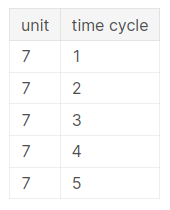

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

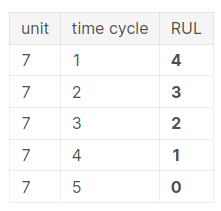

In [16]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr") #so for each group(grp 1, grp 2, ..... ,grp 100)
    max_cycle = grouped_by_unit["time_cycles"].max() #we find the max time cycle for each group

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"] #max_cycle talks about the maximum cycle befor it fails and time_cycle is the current cycle state
    result_frame["RUL"] = remaining_useful_life #that calculation is stored here

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
#train=train.drop(['unit_nr','time_cycles','setting_1','setting_2'], axis=1)
train[sensor_names+['RUL']]

s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  641.82  1589.70  1400.60  14.62  21.61  554.36  2388.06   
1      518.67  642.15  1591.82  1403.14  14.62  21.61  553.75  2388.04   
2      518.67  642.35  1587.99  1404.20  14.62  21.61  554.26  2388.08   
3      518.67  642.35  1582.79  1401.87  14.62  21.61  554.45  2388.11   
4      518.67  642.37  1582.85  1406.22  14.62  21.61  554.00  2388.06   
...       ...     ...      ...      ...    ...    ...     ...      ...   
20626  518.67  643.49  1597.98  1428.63  14.62  21.61  551.43  2388.19   
20627  518.67  643.54  1604.50  1433.58  14.62  21.61  550.86  2388.23   
20628  518.67  643.42  1602.46  1428.18  14.62  21.61  550.94  2388.24   
20629  518.67  643.23  1605.26  1426.53  14.62  21.61  550.68  2388.25   
20630  518.67  643.85  1600.38  1432.14  14.62  21.61  550.79  2388.26   

           s_9  s_10   s_11    s_12     s_13     s_14    s_15  s_16  s_17  \
0      9046.19   1.3  47.47  521.66  2388.02  8138.62  8.4195  0.03   392   
1      9044.07   1.3  47.49  522.28  2388.07  8131.49  8.4318  0.03   392   
2      9052.94   1.3  47.27  522.42  2388.03  8133.23  8.4178  0.03   390   
3      9049.48   1.3  47.13  522.86  2388.08  8133.83  8.3682  0.03   392   
4      9055.15   1.3  47.28  522.19  2388.04  8133.80  8.4294  0.03   393   
...        ...   ...    ...     ...      ...      ...     ...   ...   ...   
20626  9065.52   1.3  48.07  519.49  2388.26  8137.60  8.4956  0.03   397   
20627  9065.11   1.3  48.04  519.68  2388.22  8136.50  8.5139  0.03   395   
20628  9065.90   1.3  48.09  520.01  2388.24  8141.05  8.5646  0.03   398   
20629  9073.72   1.3  48.39  519.67  2388.23  8139.29  8.5389  0.03   395   
20630  9061.48   1.3  48.20  519.30  2388.26  8137.33  8.5036  0.03   396   

       s_18   s_19   s_20     s_21  RUL  
0      2388  100.0  39.06  23.4190  191  
1      2388  100.0  39.00  23.4236  190  
2      2388  100.0  38.95  23.3442  189  
3      2388  100.0  38.88  23.3739  188  
4      2388  100.0  38.90  23.4044  187  
...     ...    ...    ...      ...  ...  
20626  2388  100.0  38.49  22.9735    4  
20627  2388  100.0  38.30  23.1594    3  
20628  2388  100.0  38.44  22.9333    2  
20629  2388  100.0  38.29  23.0640    1  
20630  2388  100.0  38.37  23.0522    0  

[20631 rows x 22 columns]

## Plotting of RUL

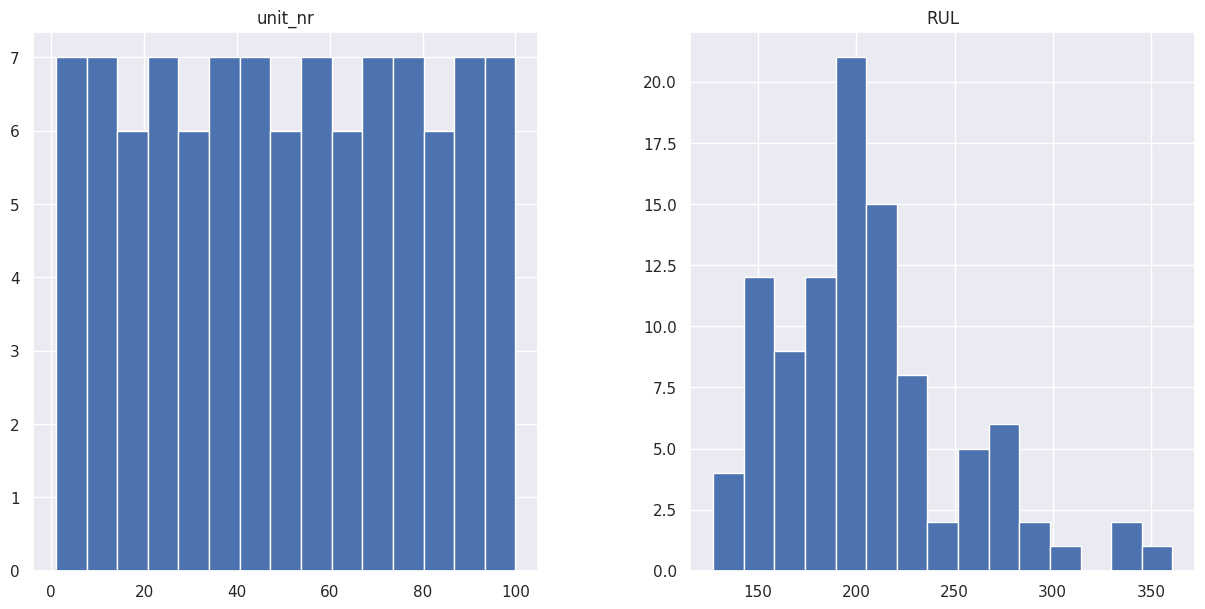

In [17]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul.hist(bins=15, figsize=(15,7))
plt.show()

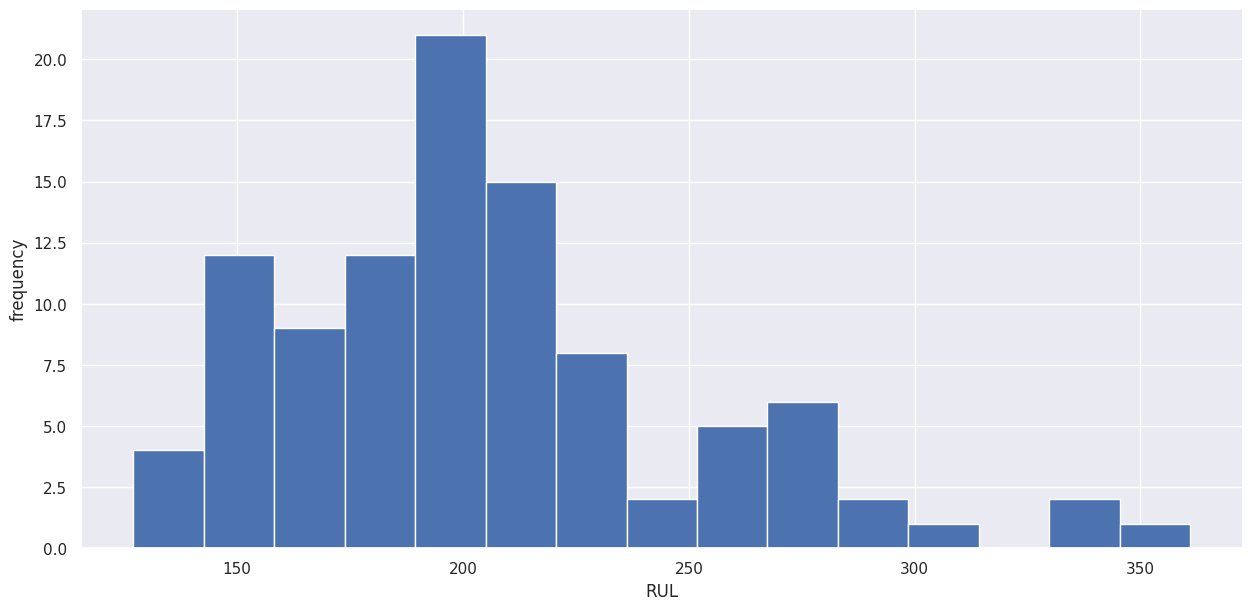

In [18]:
# distribution of "max" RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [19]:
# We can see the RUL for engine is bit skewed on left side.
# This may affect perfomance of the model.
# However, we will ignore it for now.

## Plotting of Sensor Values Vs RUL

We will first plot all the sensors data for an engine (e.g., unit_nr = 4), and then the sensors data for all the engines.

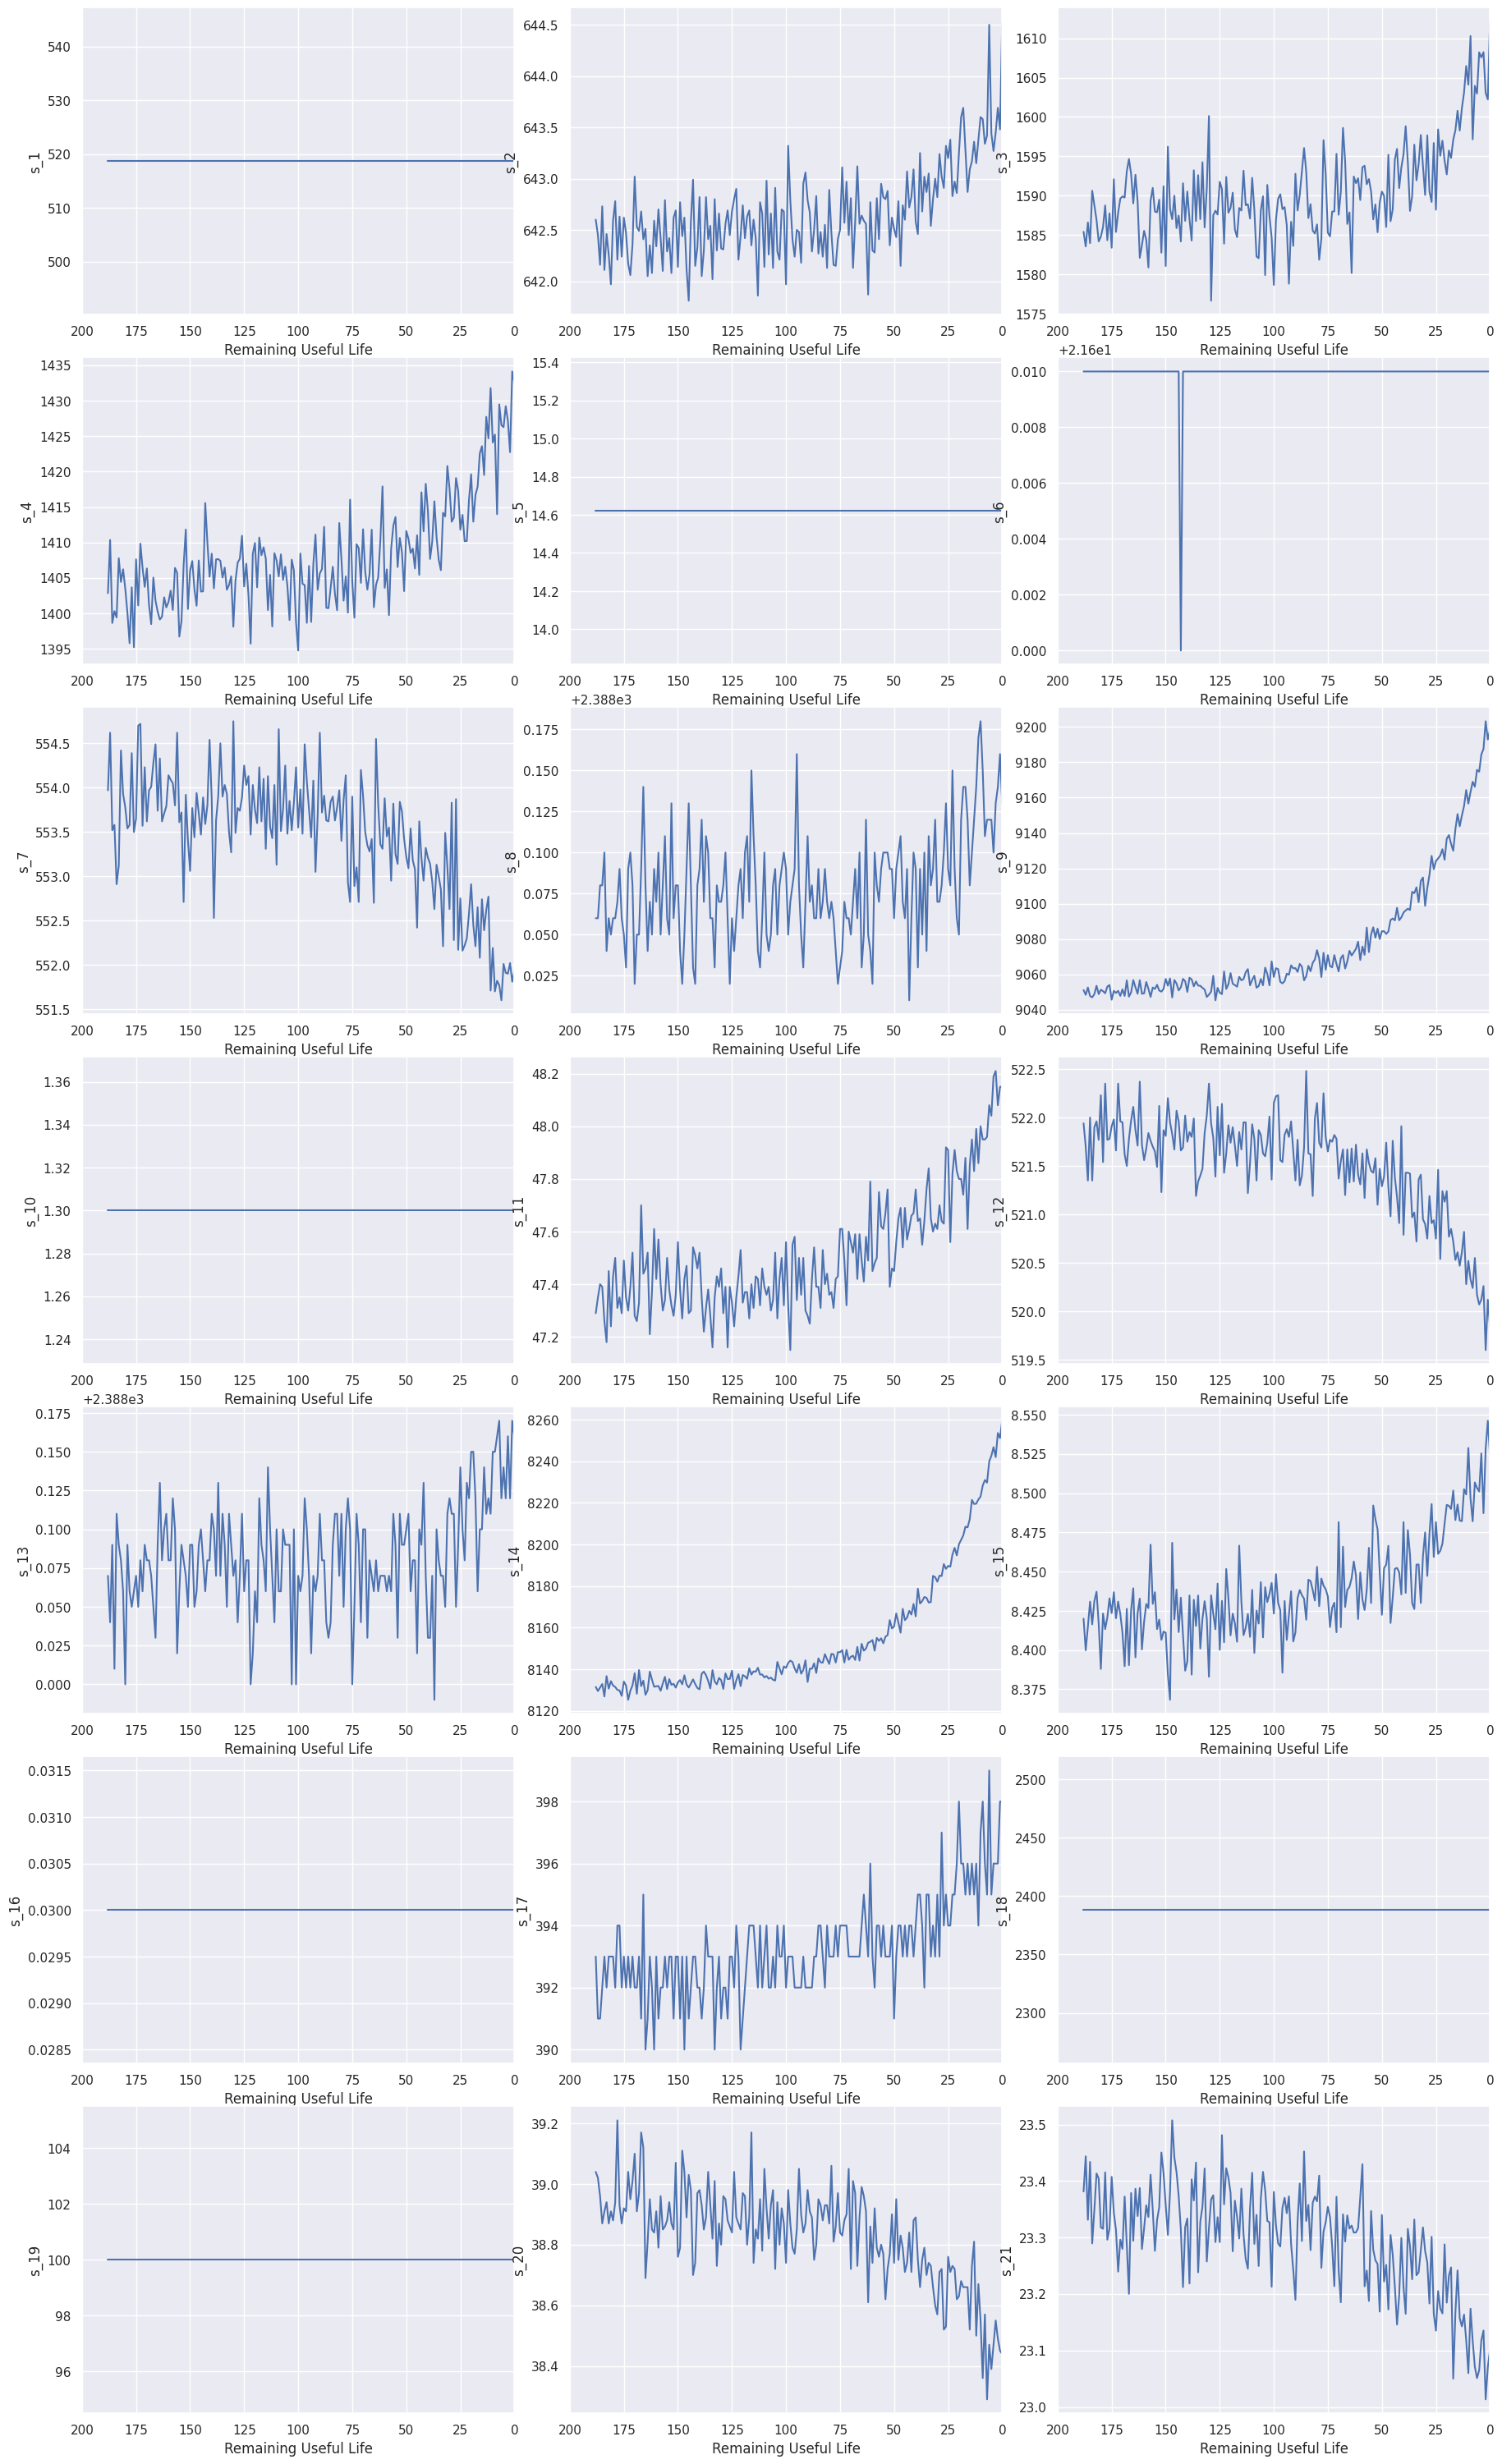

In [20]:
fig, axes = plt.subplots(7,3, figsize = (18,30))
fig.tight_layout()
for i, sensor_name in enumerate(sensor_names):
  axes[i // 3, i % 3].plot('RUL',
           sensor_name,
           data=train[train['unit_nr']==4])
  axes[i // 3, i % 3].set_xlabel('Remaining Useful Life')
  axes[i // 3, i % 3].set_ylabel(sensor_name)
  axes[i // 3, i % 3].set_xlim(200,0)

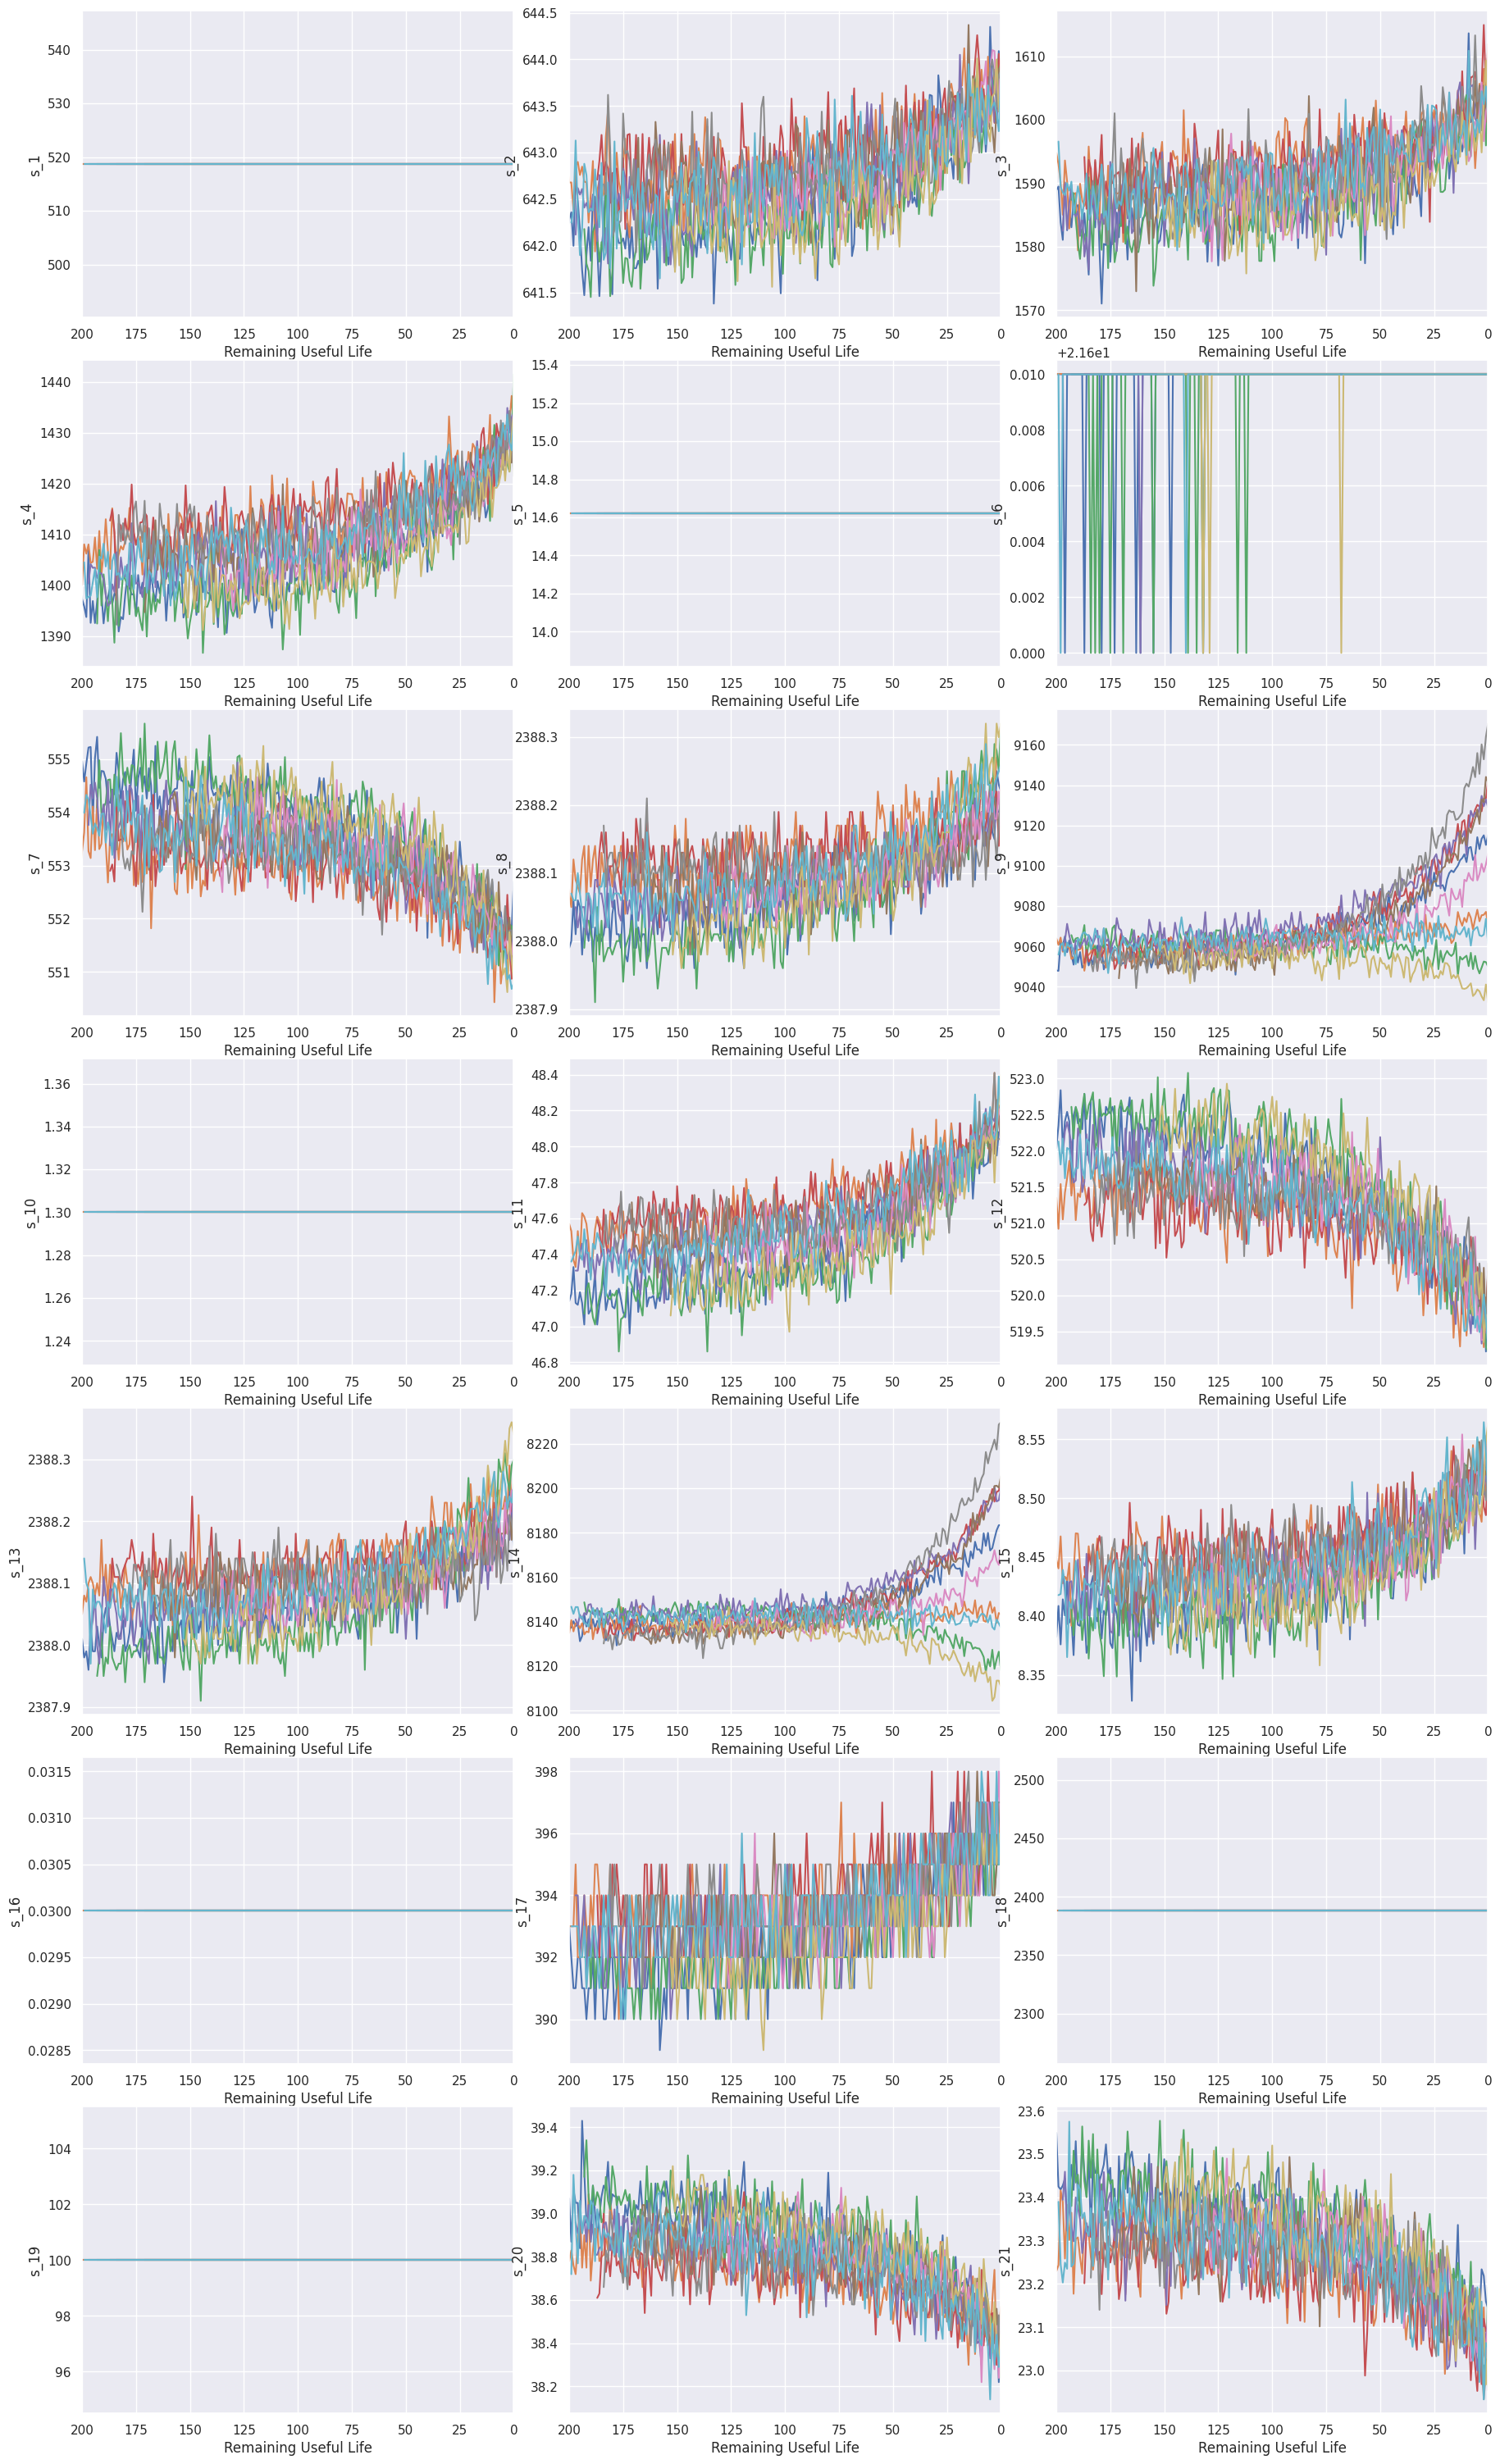

In [21]:
fig, axes = plt.subplots(7,3, figsize = (18,30))
fig.tight_layout()
for i, sensor_name in enumerate(sensor_names):
   for j in train['unit_nr'].unique():
        if (j % 10 == 0): # only plot every 10th unit_nr
          axes[i // 3, i % 3].plot('RUL',
           sensor_name,
           data=train[train['unit_nr']==j])
          axes[i // 3, i % 3].set_xlabel('Remaining Useful Life')
          axes[i // 3, i % 3].set_ylabel(sensor_name)
          axes[i // 3, i % 3].set_xlim(200,0)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Extraction of only Important Features which have strong relation affecting RUL of engine

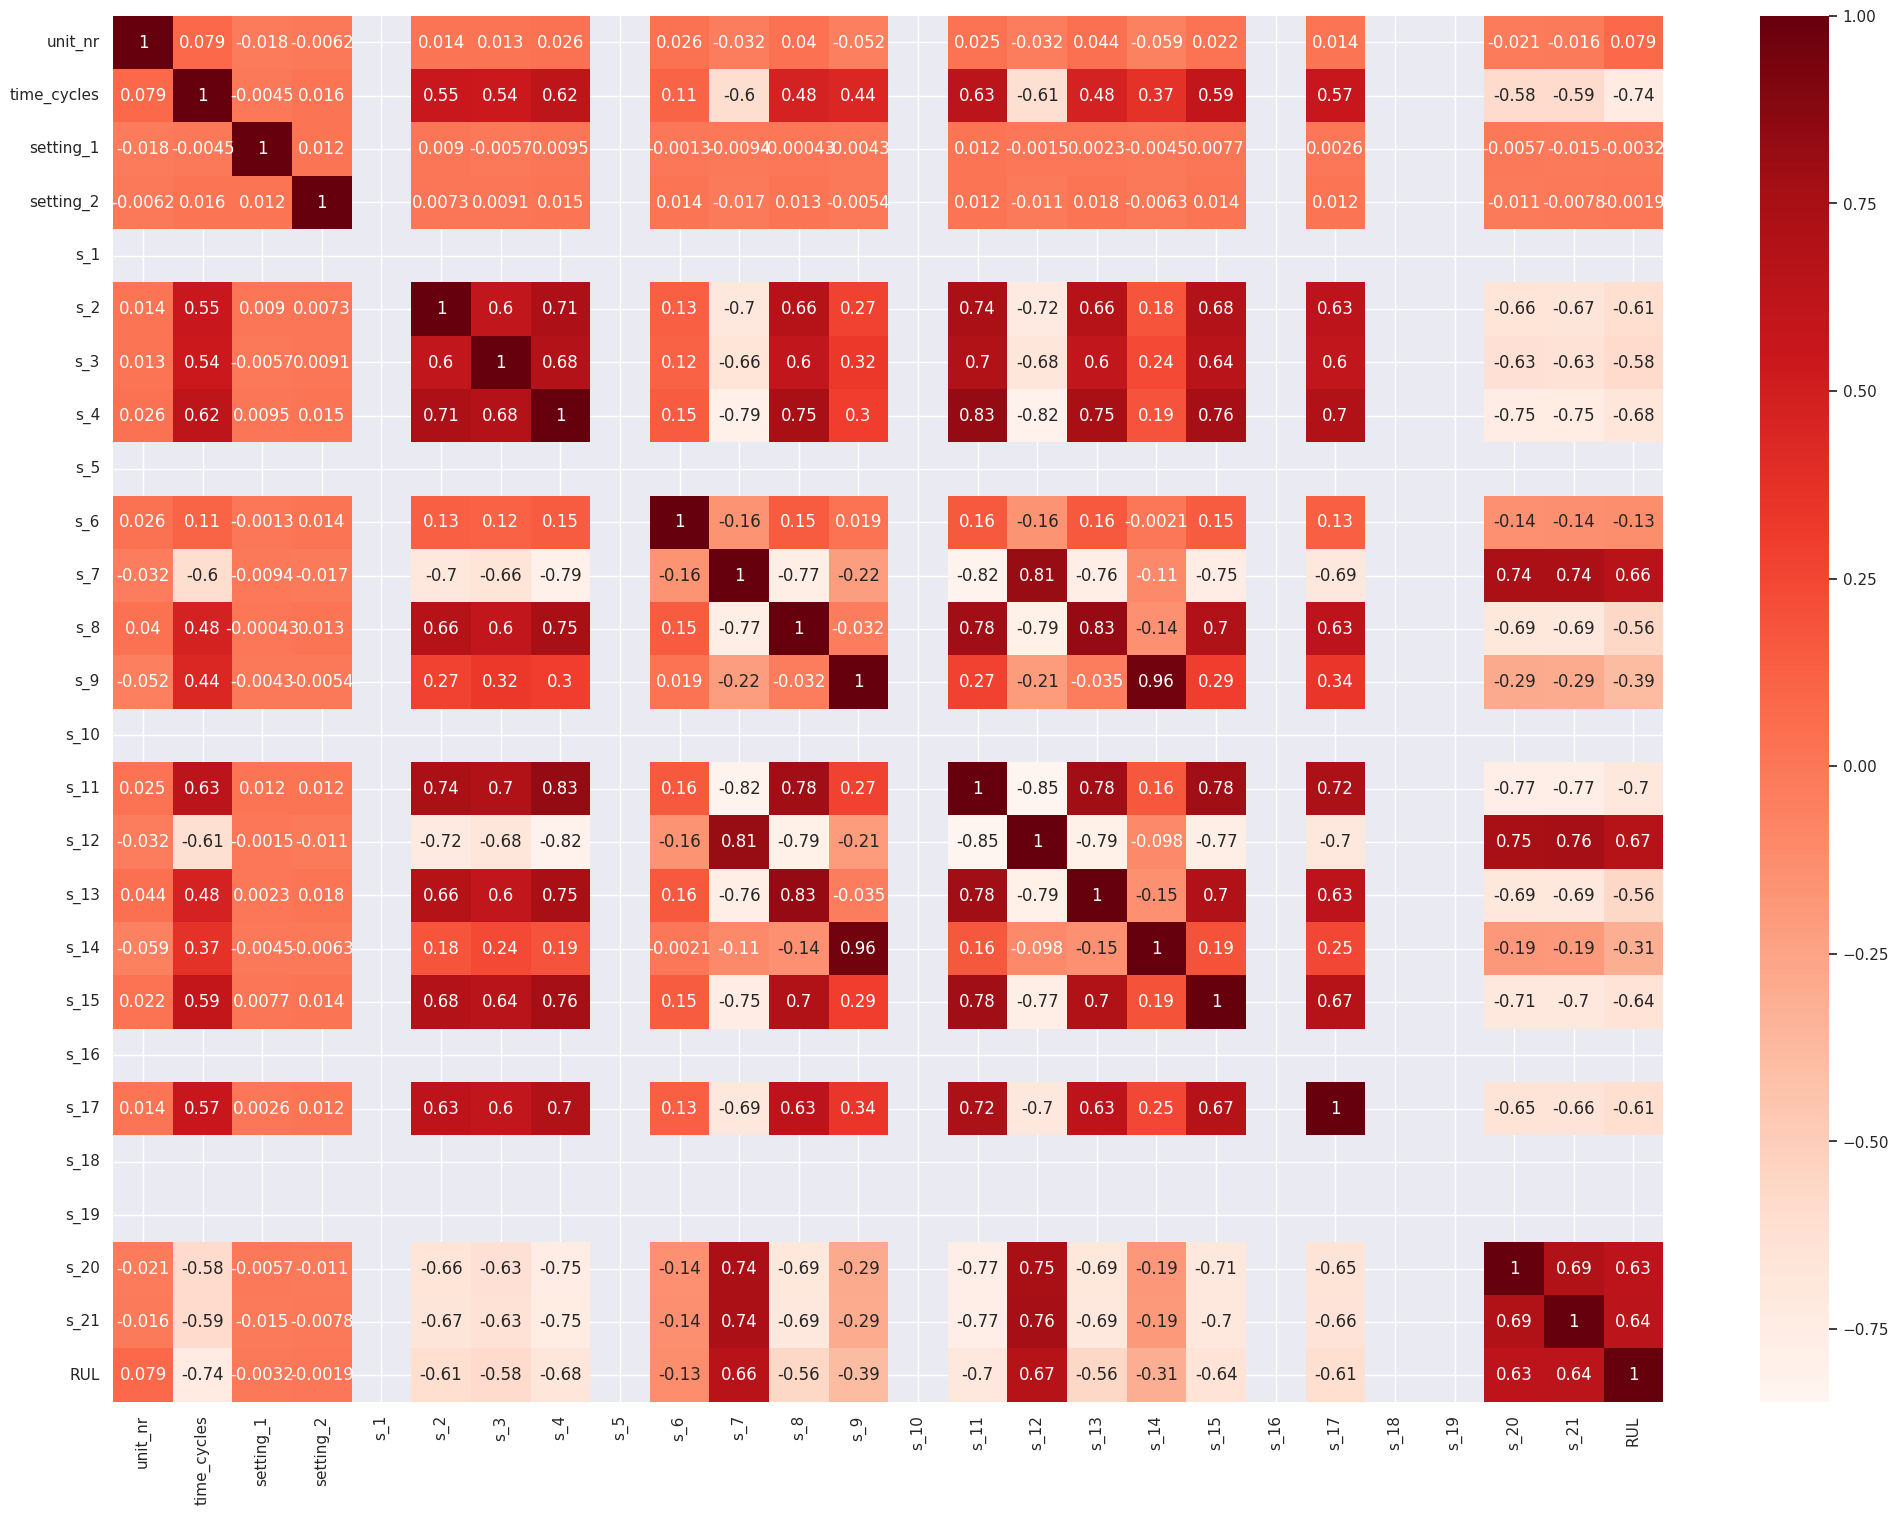

In [22]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [23]:
cor=train.corr()
cor

unit_nr  time_cycles  setting_1  setting_2  s_1       s_2  \
unit_nr      1.000000     0.078753  -0.017895  -0.006197  NaN  0.014133   
time_cycles  0.078753     1.000000  -0.004527   0.016132  NaN  0.549898   
setting_1   -0.017895    -0.004527   1.000000   0.011660  NaN  0.009030   
setting_2   -0.006197     0.016132   0.011660   1.000000  NaN  0.007266   
s_1               NaN          NaN        NaN        NaN  NaN       NaN   
s_2          0.014133     0.549898   0.009030   0.007266  NaN  1.000000   
s_3          0.012621     0.543947  -0.005651   0.009068  NaN  0.602610   
s_4          0.026116     0.624577   0.009544   0.014673  NaN  0.714949   
s_5               NaN          NaN        NaN        NaN  NaN       NaN   
s_6          0.026431     0.105980  -0.001340   0.014355  NaN  0.132242   
s_7         -0.032073    -0.595914  -0.009437  -0.016678  NaN -0.702136   
s_8          0.039929     0.475977  -0.000427   0.013285  NaN  0.662325   
s_9         -0.052053     0.443999  -0.004279  -0.005425  NaN  0.273764   
s_10              NaN          NaN        NaN        NaN  NaN       NaN   
s_11         0.024707     0.634385   0.011658   0.011690  NaN  0.740020   
s_12        -0.031882    -0.611354  -0.001491  -0.010923  NaN -0.724578   
s_13         0.044230     0.477523   0.002318   0.018156  NaN  0.661792   
s_14        -0.059473     0.370324  -0.004469  -0.006310  NaN  0.179752   
s_15         0.022486     0.588676   0.007652   0.014156  NaN  0.675975   
s_16              NaN          NaN        NaN        NaN  NaN       NaN   
s_17         0.013513     0.566995   0.002599   0.012280  NaN  0.629886   
s_18              NaN          NaN        NaN        NaN  NaN       NaN   
s_19              NaN          NaN        NaN        NaN  NaN       NaN   
s_20        -0.020589    -0.583597  -0.005713  -0.010554  NaN -0.661841   
s_21        -0.016465    -0.585923  -0.014559  -0.007846  NaN -0.668050   
RUL          0.078753    -0.736241  -0.003198  -0.001948  NaN -0.606484   

                  s_3       s_4  s_5       s_6       s_7       s_8       s_9  \
unit_nr      0.012621  0.026116  NaN  0.026431 -0.032073  0.039929 -0.052053   
time_cycles  0.543947  0.624577  NaN  0.105980 -0.595914  0.475977  0.443999   
setting_1   -0.005651  0.009544  NaN -0.001340 -0.009437 -0.000427 -0.004279   
setting_2    0.009068  0.014673  NaN  0.014355 -0.016678  0.013285 -0.005425   
s_1               NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_2          0.602610  0.714949  NaN  0.132242 -0.702136  0.662325  0.273764   
s_3          1.000000  0.678413  NaN  0.116039 -0.664595  0.602481  0.322964   
s_4          0.678413  1.000000  NaN  0.150480 -0.793130  0.746852  0.297429   
s_5               NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_6          0.116039  0.150480  NaN  1.000000 -0.155720  0.152161  0.019347   
s_7         -0.664595 -0.793130  NaN -0.155720  1.000000 -0.767132 -0.217835   
s_8          0.602481  0.746852  NaN  0.152161 -0.767132  1.000000 -0.032091   
s_9          0.322964  0.297429  NaN  0.019347 -0.217835 -0.032091  1.000000   
s_10              NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_11         0.695900  0.830136  NaN  0.160014 -0.822805  0.782213  0.274591   
s_12        -0.680307 -0.815591  NaN -0.155884  0.812713 -0.786540 -0.210238   
s_13         0.600963  0.745158  NaN  0.158276 -0.764611  0.826084 -0.034763   
s_14         0.237137  0.190748  NaN -0.002112 -0.110053 -0.144787  0.963157   
s_15         0.639921  0.758459  NaN  0.149042 -0.747051  0.700949  0.293753   
s_16              NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_17         0.600017  0.703499  NaN  0.130810 -0.692893  0.627785  0.337110   
s_18              NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_19              NaN       NaN  NaN       NaN       NaN       NaN       NaN   
s_20        -0.625941 -0.748067  NaN -0.141419  0.736163 -0.687030 -

In [24]:
cor_target = abs(cor["RUL"])
cor_target

unit_nr        0.078753
time_cycles    0.736241
setting_1      0.003198
setting_2      0.001948
s_1                 NaN
s_2            0.606484
s_3            0.584520
s_4            0.678948
s_5                 NaN
s_6            0.128348
s_7            0.657223
s_8            0.563968
s_9            0.390102
s_10                NaN
s_11           0.696228
s_12           0.671983
s_13           0.562569
s_14           0.306769
s_15           0.642667
s_16                NaN
s_17           0.606154
s_18                NaN
s_19                NaN
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [25]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles   -0.736241
s_2           -0.606484
s_3           -0.584520
s_4           -0.678948
s_7            0.657223
s_8           -0.563968
s_11          -0.696228
s_12           0.671983
s_13          -0.562569
s_15          -0.642667
s_17          -0.606154
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [26]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [27]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [28]:
# Now we will keep only these important features in both train & test dataset.
train=train[list_relevant_features]

In [29]:
train.head(5)

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0  641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02  8.4195   
1  642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07  8.4318   
2  642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03  8.4178   
3  642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08  8.3682   
4  642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04  8.4294   

   s_17   s_20     s_21  RUL  
0   392  39.06  23.4190  191  
1   392  39.00  23.4236  190  
2   390  38.95  23.3442  189  
3   392  38.88  23.3739  188  
4   393  38.90  23.4044  187

## Seperating Train & Test Data

In [30]:
# train & y_train
# Calculated RUL variable is our Target variable.
RUL_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13  \
0      641.82  1589.70  1400.60  554.36  2388.06  47.47  521.66  2388.02   
1      642.15  1591.82  1403.14  553.75  2388.04  47.49  522.28  2388.07   
2      642.35  1587.99  1404.20  554.26  2388.08  47.27  522.42  2388.03   
3      642.35  1582.79  1401.87  554.45  2388.11  47.13  522.86  2388.08   
4      642.37  1582.85  1406.22  554.00  2388.06  47.28  522.19  2388.04   
...       ...      ...      ...     ...      ...    ...     ...      ...   
20626  643.49  1597.98  1428.63  551.43  2388.19  48.07  519.49  2388.26   
20627  643.54  1604.50  1433.58  550.86  2388.23  48.04  519.68  2388.22   
20628  643.42  1602.46  1428.18  550.94  2388.24  48.09  520.01  2388.24   
20629  643.23  1605.26  1426.53  550.68  2388.25  48.39  519.67  2388.23   
20630  643.85  1600.38  1432.14  550.79  2388.26  48.20  519.30  2388.26   

         s_15  s_17   s_20     s_21  
0      8.4195   392  39.06  23.4190  
1      8.4318   392  39.00  23.4236  
2      8.4178   390  38.95  23.3442  
3      8.3682   392  38.88  23.3739  
4      8.4294   393  38.90  23.4044  
...       ...   ...    ...      ...  
20626  8.4956   397  38.49  22.9735  
20627  8.5139   395  38.30  23.1594  
20628  8.5646   398  38.44  22.9333  
20629  8.5389   395  38.29  23.0640  
20630  8.5036   396  38.37  23.0522  

[20631 rows x 12 columns]

In [31]:
RUL_train.head()

0    191
1    190
2    189
3    188
4    187
Name: RUL, dtype: int64

In [32]:
test

setting_1  setting_2  setting_3     s_1     s_2      s_3      s_4    s_5  \
0     -0.0006     0.0004      100.0  518.67  642.58  1581.22  1398.91  14.62   
1      0.0018    -0.0001      100.0  518.67  642.55  1586.59  1410.83  14.62   
2     -0.0016     0.0004      100.0  518.67  642.88  1589.75  1418.89  14.62   
3      0.0012     0.0004      100.0  518.67  642.78  1594.53  1406.88  14.62   
4     -0.0013    -0.0004      100.0  518.67  642.27  1589.94  1419.36  14.62   
..        ...        ...        ...     ...     ...      ...      ...    ...   
95    -0.0006     0.0003      100.0  518.67  642.30  1590.88  1397.94  14.62   
96     0.0013    -0.0001      100.0  518.67  642.59  1582.96  1410.92  14.62   
97     0.0017     0.0001      100.0  518.67  642.68  1599.51  1415.47  14.62   
98     0.0047    -0.0000      100.0  518.67  642.00  1585.03  1397.98  14.62   
99     0.0013     0.0003      100.0  518.67  642.95  1601.62  1424.99  14.62   

      s_6     s_7      s_8      s_9  s_10   s_11    s_12     s_13     s_14  \
0   21.61  554.42  2388.08  9056.40   1.3  47.23  521.79  2388.06  8130.11   
1   21.61  553.52  2388.10  9044.77   1.3  47.67  521.74  2388.09  8126.90   
2   21.61  552.59  2388.16  9049.26   1.3  47.88  520.83  2388.14  8131.46   
3   21.61  552.64  2388.13  9051.30   1.3  47.65  521.88  2388.11  8133.64   
4   21.61  553.29  2388.10  9053.99   1.3  47.46  521.00  2388.15  8125.74   
..    ...     ...      ...      ...   ...    ...     ...      ...      ...   
95  21.61  553.99  2388.03  9062.41   1.3  47.14  522.30  2388.01  8148.24   
96  21.61  554.05  2388.06  9076.36   1.3  47.38  521.58  2388.06  8155.48   
97  21.61  553.44  2388.13  9062.34   1.3  47.66  521.53  2388.09  8146.39   
98  21.61  554.75  2388.01  9067.16   1.3  47.26  521.82  2388.02  8150.38   
99  21.61  552.48  2388.06  9155.03   1.3  47.80  521.07  2388.05  8214.64   

      s_15  s_16  s_17  s_18   s_19   s_20     s_21  
0   8.4024  0.03   393  2388  100.0  38.81  23.3552  
1   8.4505  0.03   391  2388  100.0  38.81  23.2618  
2   8.4119  0.03   395  2388  100.0  38.93  23.2740  
3   8.4634  0.03   395  2388  100.0  38.58  23.2581  
4   8.4362  0.03   394  2388  100.0  38.75  23.4117  
..     ...   ...   ...   ...    ...    ...      ...  
95  8.4110  0.03   391  2388  100.0  38.96  23.4606  
96  8.4500  0.03   395  2388  100.0  38.61  23.2953  
97  8.4235  0.03   394  2388  100.0  38.76  23.3608  
98  8.4003  0.03   391  2388  100.0  38.95  23.3595  
99  8.4903  0.03   396  2388  100.0  38.70  23.1855  

[100 rows x 24 columns]

In [33]:
# Test data set , keeping only train columns/features.
#X_test=test[X_train.columns]
#X_test.head(5)

In [34]:
# Test data set , keeping only train columns/features.
X_test=test[list_relevant_features.drop('RUL')]
X_test

s_2      s_3      s_4     s_7      s_8   s_11    s_12     s_13    s_15  \
0   642.58  1581.22  1398.91  554.42  2388.08  47.23  521.79  2388.06  8.4024   
1   642.55  1586.59  1410.83  553.52  2388.10  47.67  521.74  2388.09  8.4505   
2   642.88  1589.75  1418.89  552.59  2388.16  47.88  520.83  2388.14  8.4119   
3   642.78  1594.53  1406.88  552.64  2388.13  47.65  521.88  2388.11  8.4634   
4   642.27  1589.94  1419.36  553.29  2388.10  47.46  521.00  2388.15  8.4362   
..     ...      ...      ...     ...      ...    ...     ...      ...     ...   
95  642.30  1590.88  1397.94  553.99  2388.03  47.14  522.30  2388.01  8.4110   
96  642.59  1582.96  1410.92  554.05  2388.06  47.38  521.58  2388.06  8.4500   
97  642.68  1599.51  1415.47  553.44  2388.13  47.66  521.53  2388.09  8.4235   
98  642.00  1585.03  1397.98  554.75  2388.01  47.26  521.82  2388.02  8.4003   
99  642.95  1601.62  1424.99  552.48  2388.06  47.80  521.07  2388.05  8.4903   

    s_17   s_20     s_21  
0    393  38.81  23.3552  
1    391  38.81  23.2618  
2    395  38.93  23.2740  
3    395  38.58  23.2581  
4    394  38.75  23.4117  
..   ...    ...      ...  
95   391  38.96  23.4606  
96   395  38.61  23.2953  
97   394  38.76  23.3608  
98   391  38.95  23.3595  
99   396  38.70  23.1855  

[100 rows x 12 columns]

In [35]:
RUL_test.head(5)

RUL
0  112
1   98
2   69
3   82
4   91

In [36]:
RUL_test.max()

RUL    145
dtype: int64

In [37]:
# Clipping of RUL at 125 as, after 125, RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.
RUL_train= RUL_train.clip(upper=125)

## Evaluation Function

In [38]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance

### Model 1: Linear Regression

In [39]:
from sklearn.preprocessing import StandardScaler
# Data scaling
sc = StandardScaler() #scaling the data before passing it as input. It is a pre-processing step in ML
X_train1 = sc.fit_transform(X_train) #fit the transformer on the train
X_test1 = sc.transform(X_test) #transformation learned during the training are implemented on the test. Same sc is user or else it will have different sc.
print(X_train1.shape,X_test1.shape)

(20631, 12) (100, 12)


In [40]:
print(X_train1.shape[1], X_test1.shape[1])

12 12


In [41]:
RUL_train.shape

(20631,)

In [42]:
RUL_test.shape

(100, 1)

In [43]:
# Create and fit model
model1 = LinearRegression()
model1.fit(X_train1, RUL_train)

# Predict and evaluate
y_hat_train1 = model1.predict(X_train1)
RMSE_Train, R2_Train = evaluate(RUL_train, y_hat_train1, 'train')

y_hat_test1 = model1.predict(X_test1)
RMSE_Test, R2_Test = evaluate(RUL_test, y_hat_test1, 'test')

train set RMSE:22.734164950962253, R2:0.7023848970100307
test set RMSE:22.91426532858463, R2:0.6959448729951724


In [44]:
# Create a Dataframe which will contain results of all applied models
Results=pd.DataFrame({'Model':['LR'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})
Results

Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0    LR   22.734165  0.702385  22.914265  0.695945

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Train Data')

<Figure size 640x480 with 0 Axes>

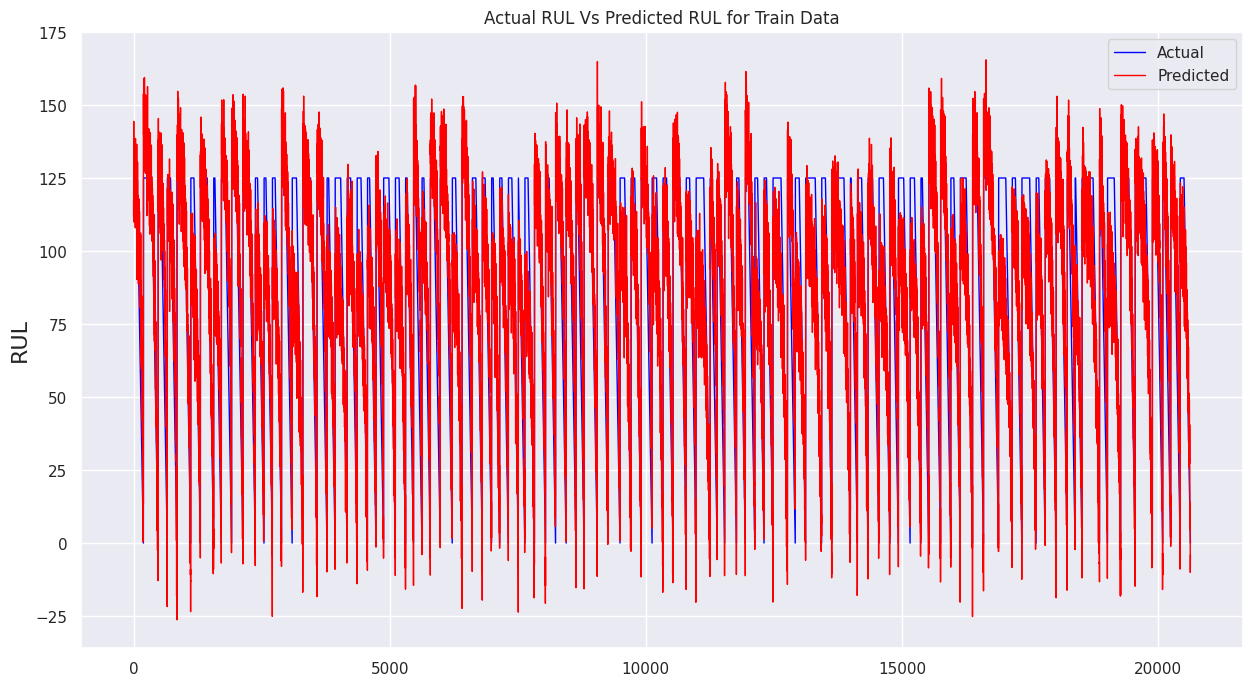

In [45]:
# Plot Actual Vs Predicted RUL for Train Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[15,8])
plt.plot(RUL_train,color="blue", linewidth=1., linestyle="-",label="Actual")
plt.plot(y_hat_train1,color="red",  linewidth=1., linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)            # Plot heading
#plt.xlabel('Index', fontsize=18)                            # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Train Data")

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 640x480 with 0 Axes>

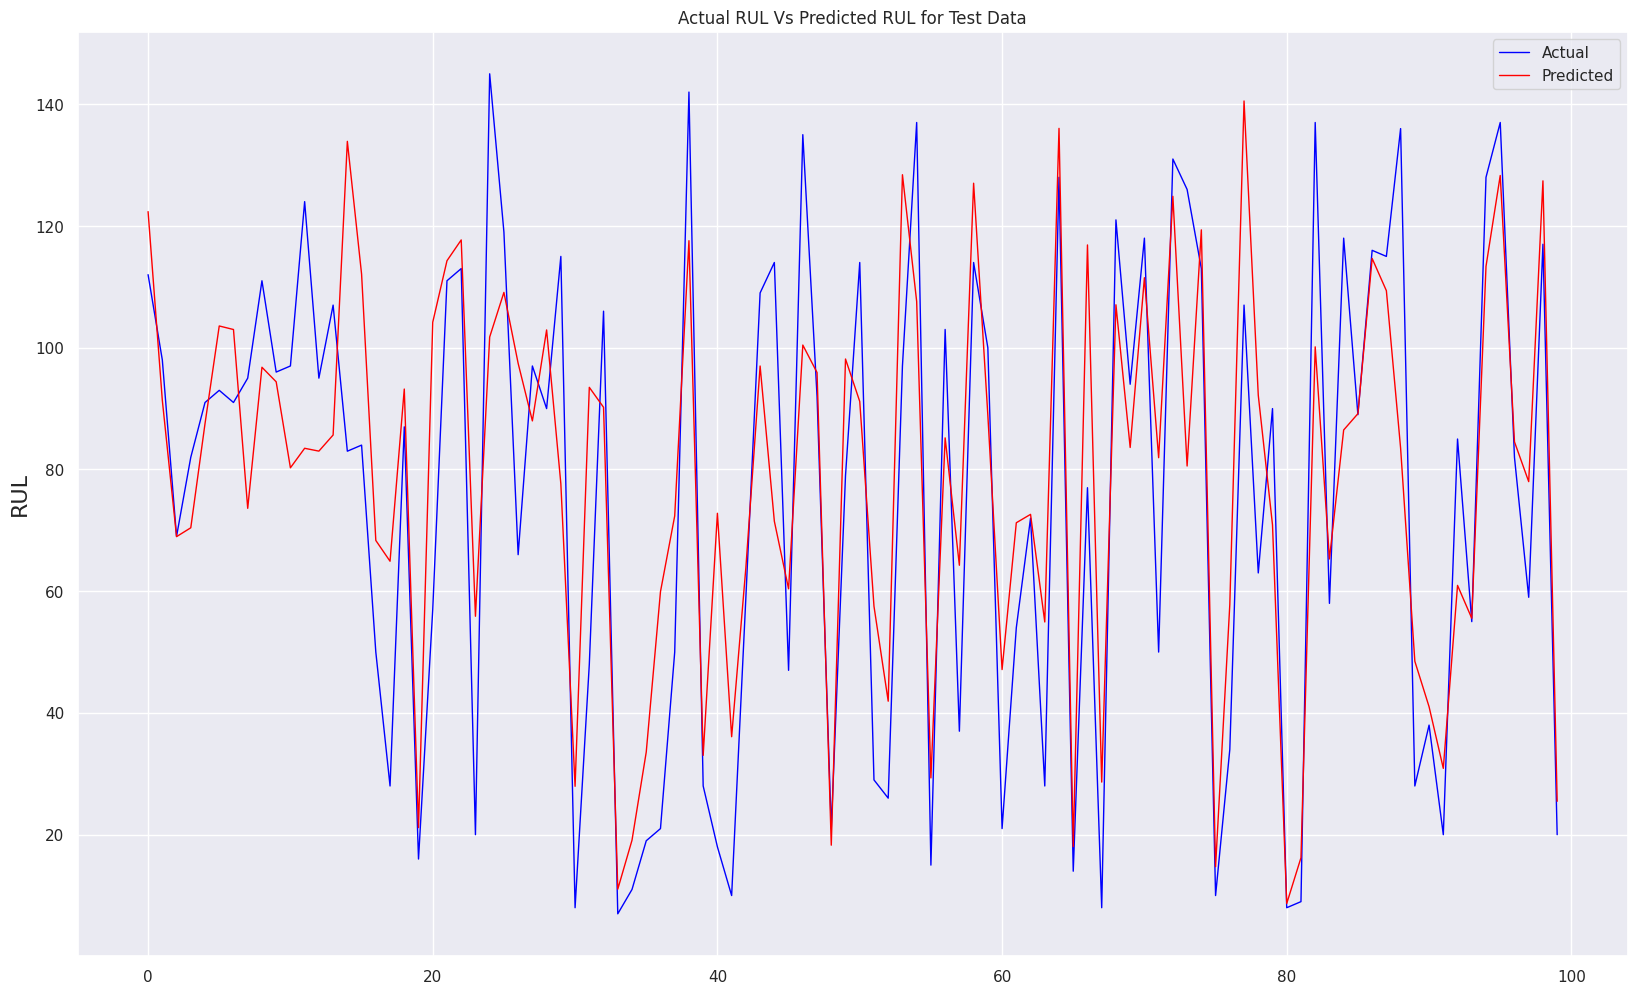

In [46]:
# Plot Actual Vs Predicted RUL for Test Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(RUL_test,color="blue", linewidth=1., linestyle="-",label="Actual")
plt.plot(y_hat_test1,color="red",  linewidth=1., linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading
#plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")

- We can see that on test data which is unseen by the model , RMSE & R2 score value comes out be 22.9 , 0.695.We will try to build further more models to see how they are performing.

### Model 2 : Applying SVM Model

In [47]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train1, RUL_train)

# predict and evaluate
y_hat_train1 = regressor.predict(X_train1)
RMSE_Train,R2_Train=evaluate(RUL_train, y_hat_train1)

y_hat_test1 = regressor.predict(X_test1)
RMSE_Test,R2_Test=evaluate(RUL_test, y_hat_test1)

test set RMSE:21.42864070146049, R2:0.7355849328257191
test set RMSE:21.82822230027631, R2:0.724083805291216


In [48]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['SVM'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

<ipython-input-48-914cbc30063d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results=Results.append(pd.DataFrame({'Model':['SVM'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0    LR   22.734165  0.702385  22.914265  0.695945
1   SVM   21.428641  0.735585  21.828222  0.724084

- We can see that RMSE for both test & train model has increased after applying SVM Model.

### Model 3 : XG Boost Algorithm

In [49]:
import xgboost as xg
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(X_train1, RUL_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:35:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [50]:
# Evaluating on Train Data Set
y_hat_train1 = xgb_r.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(RUL_train, y_hat_train1, 'train')

train set RMSE:19.466328547996255, R2:0.7817948225955222


In [51]:
# Evaluating on Test Data Set
y_hat_test1 = xgb_r.predict(X_test1)
RMSE_Test,R2_Test=evaluate(RUL_test, y_hat_test1)

test set RMSE:20.37124692553307, R2:0.7596878760845401


In [52]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['XgBoost'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

<ipython-input-52-2444483a8748>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results=Results.append(pd.DataFrame({'Model':['XgBoost'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0       LR   22.734165  0.702385  22.914265  0.695945
1      SVM   21.428641  0.735585  21.828222  0.724084
2  XgBoost   19.466329  0.781795  20.371247  0.759688

- With Xgboost model accuracy has increased. We can see that over model is not overfitting as XGboost offers regularized gradient boosting framework.

# Model 4: Artificial Neural Network (ANN)

In the following, we will build a simple mlp-based ANN to estimate the RUL values.

In [53]:
class NASA_Dataset(torch.utils.data.Dataset):
  '''
  Prepare the dataset for regression
  '''

  def __init__(self, X, y, scale_data=False):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [88]:
## Create an ANN composed by linear layers to predict the RUL value.
## The number of input features is 12 while the output should be just one value.
## Implement also the forward pass

class ANN(nn.Module):
  def __init__(self, ):
    super(ANN,self).__init__()

    self.fc1=nn.Linear(12, 256)
    self.relu=nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(256, 1)
    self.sigmoid=nn.Sigmoid()

  def forward(self, x):
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    x=self.relu(x)
    return x


In [89]:
# Set fixed random number seed
torch.manual_seed(7)

# Prepare dataset
dataset = NASA_Dataset(X_train1, RUL_train.to_numpy())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=1)

# Initialize the network
model4=ANN()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=3e-4)

In [90]:
# Run the training loop
for epoch in range(0, 100): # 100 epochs at maximum

    # Set current loss value
    running_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Check if inputs is None (possibly due to an issue with the DataLoader)
        if inputs is None:
            print("Inputs are None. Check the DataLoader.")
            break

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = model4(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

# Process is complete.
print('Training process has finished.')


[1,   200] loss: 8687.995
[2,   200] loss: 6414.768
[3,   200] loss: 3931.573
[4,   200] loss: 3122.503
[5,   200] loss: 2814.919
[6,   200] loss: 2437.929
[7,   200] loss: 2014.228
[8,   200] loss: 1618.077
[9,   200] loss: 1286.477
[10,   200] loss: 1011.399
[11,   200] loss: 814.708
[12,   200] loss: 693.722
[13,   200] loss: 623.380
[14,   200] loss: 584.405
[15,   200] loss: 565.248
[16,   200] loss: 555.514
[17,   200] loss: 547.977
[18,   200] loss: 543.207
[19,   200] loss: 539.515
[20,   200] loss: 532.028
[21,   200] loss: 528.723
[22,   200] loss: 522.501
[23,   200] loss: 518.527
[24,   200] loss: 512.388
[25,   200] loss: 506.551
[26,   200] loss: 501.815
[27,   200] loss: 497.760
[28,   200] loss: 493.108
[29,   200] loss: 487.653
[30,   200] loss: 483.517
[31,   200] loss: 479.087
[32,   200] loss: 475.448
[33,   200] loss: 471.666
[34,   200] loss: 468.548
[35,   200] loss: 466.344
[36,   200] loss: 464.766
[37,   200] loss: 460.654
[38,   200] loss: 459.126
[39,   200]

In [91]:
# predict and evaluate
y_hat_train1 = model4(torch.tensor(X_train1, dtype=torch.float32))
RMSE_Train, R2_Train = evaluate(RUL_train, y_hat_train1.detach().numpy(),'train')

y_hat_test1 = model4(torch.tensor(X_test1, dtype=torch.float32))
RMSE_Test,R2_Test = evaluate(RUL_test, y_hat_test1.detach().numpy(),'test')

train set RMSE:20.967070564793588, R2:0.7468531856112992
test set RMSE:21.244445982007463, R2:0.7386447215919296


In [92]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['ANN'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

<ipython-input-92-feab7911cb23>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results=Results.append(pd.DataFrame({'Model':['ANN'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)


Model  RMSE-Train  R2-Train  RMSE-Test   R2-Test
0       LR   22.734165  0.702385  22.914265  0.695945
1      SVM   21.428641  0.735585  21.828222  0.724084
2  XgBoost   19.466329  0.781795  20.371247  0.759688
3      ANN   20.967071  0.746853  21.244446  0.738645

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 640x480 with 0 Axes>

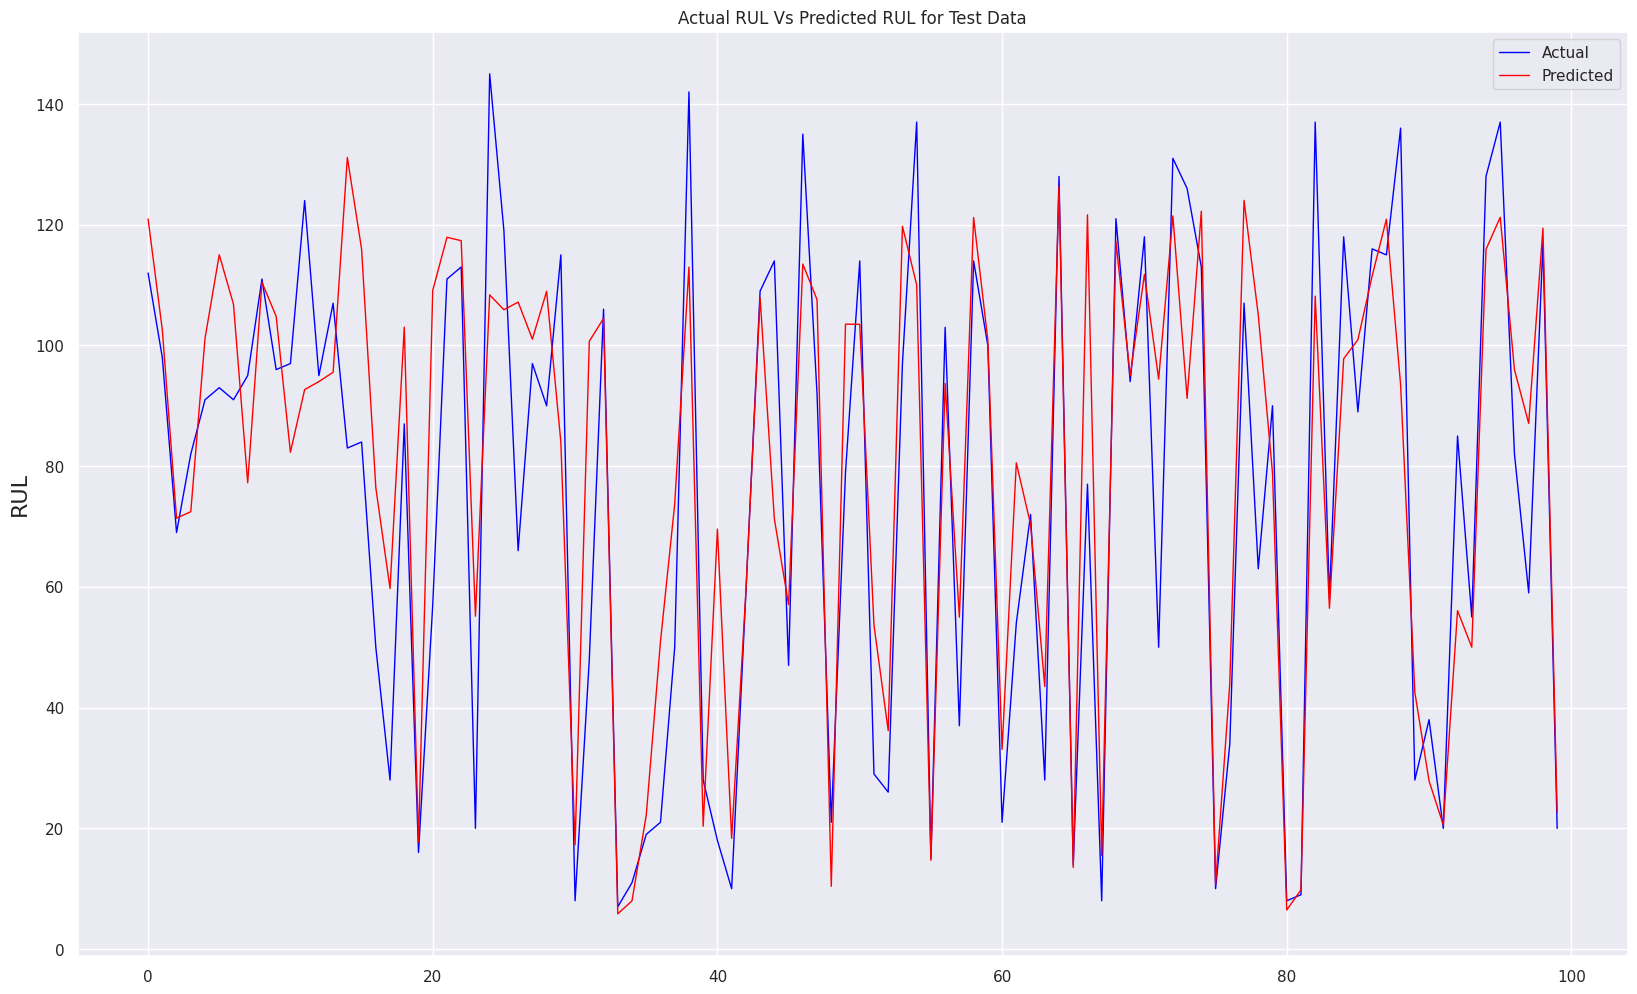

In [93]:
# Plot Actual Vs Predicted RUL for Test Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(RUL_test,color="blue", linewidth=1., linestyle="-",label="Actual")
plt.plot(y_hat_test1.detach().numpy(),color="red",  linewidth=1., linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading
#plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")

# Model 5: Recurrent Neural Network (RNN)

In this example, we will use an RNN. First, we need to create sequences of data. We will consider sequences of length 10. So, for the training engines, we will consider all the sequences with length 10 while, for the testing engines, we will only retain the last 10 cycles.

In [95]:
#Load train/test data
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL/test_FD001.txt',sep='\s+', header=None, names=col_names)

In [96]:
# Max seq_length
max_seq_length = test.groupby('unit_nr').size().to_numpy().min()
print(f'Max sequence length: {max_seq_length}')

# Reshape test data according to windows of size seq_length
seq_length = 10 # must be less than or equalt to max_seq_length
test = test.groupby('unit_nr').tail(seq_length).drop(['unit_nr','time_cycles'], axis=1).reset_index()
print(test.shape)

Max sequence length: 31
(1000, 25)


In [97]:
# Select features
X_test=test[X_train.columns]
# Apply scaling
X_test1 = sc.transform(X_test)
# Print dims
print(X_test1.shape)

(1000, 12)


Now, we will create our dataloader.

In [98]:
class NASA_Dataset(torch.utils.data.Dataset):
  '''
  Prepare the dataset for regression
  '''

  def __init__(self, X, y, scale_data=False):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
    # Remove last seq_length elements
    return len(self.X)-seq_length

  def __getitem__(self, i):
    # Consider windows of length "seq_length" as features
    # and last RUL of the sequence for the target variable
    return self.X[i:i+seq_length], self.y[i+(seq_length-1)]

In [108]:
## Create an ANN based on an RNN to predict the RUL value.
## For example, you may consider this simple network: RNN -> linear layer

## For the RNN you must specify the input_size (number of input features)
## hidden_size (number of features in the hidden state h) and number of layers (for example, 1)
##
## The output (linear) layer should map a vector of hidden_size to the output dimension (which is 1)
##
##  You can follow this steps:
##             1. Define the hidden dimension
##             2. Define the number of layers
##             3. Define the RNN using the previous parameters
##                     (set batch_first=True) (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
##             4. Define the linear layer
##             5. Define the forward method
##                5.1. Create an hidden state (initialized with zeros) of dimension (num_layers, batch_size, hidden_dimension)
##                5.2. Apply your RNN using the input and the previous initialized hidden state
##                5.3. Extract the last timestep from each sequence in order to reshape [batch_size, seq_length, h] => [batch_size, h]
##                5.4. Apply the linear layer to map  [batch_size, h] to [batch_size, 1]
##                5.5. Reshape the output to remove the first dimension and obtain a shape of [batch_size].
##
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layer, output_size):
    super(RNN,self).__init__()

    self.hidden_size=hidden_size
    self.num_layer=num_layer

    self.rnn=nn.RNN(input_size,hidden_size, num_layer, batch_first=True)

    self.linear=nn.Linear(hidden_size, output_size)


  def forward(self, x):

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layer, x.size(0), self.hidden_size).requires_grad_()

        out, hn = self.rnn(x, h0.detach())
        # [batch_size, seq, h] => [batch_size, h]
        out = out[:, -1, :]  # extract last timestep
        # linear layer so that output is not [batch_size,h] but [batch_size, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [batch_size, h] => [batch_size, 1]

        out = out.squeeze(dim=1)  # => [batch_size]
        return out



In [109]:
# Set fixed random number seed
torch.manual_seed(11)

# Prepare dataset
batch_size = 30
dataset = NASA_Dataset(X_train1, RUL_train.to_numpy())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Initialize the RNN model
input_size = 12
hidden_size = 128
output_size = 1
num_layer = 1
model = RNN(input_size, hidden_size, num_layer, output_size)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [110]:
# Run the training loop
for epoch in range(0, 20): # 20 epochs at maximum

  # # Print epoch
  # print(f'Starting epoch {epoch+1}')

  # Set current loss value
  running_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):

    # Get and prepare inputs
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()

    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass
    outputs = model(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:    # print every 200 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
        running_loss = 0.0

# Process is complete.
print('Training process has finished.')

[1,   200] loss: 7916.204
[1,   400] loss: 6560.914
[1,   600] loss: 5497.862
[2,   200] loss: 4475.602
[2,   400] loss: 3757.241
[2,   600] loss: 3330.134
[3,   200] loss: 2729.610
[3,   400] loss: 2487.833
[3,   600] loss: 2265.363
[4,   200] loss: 2028.262
[4,   400] loss: 1913.183
[4,   600] loss: 1776.961
[5,   200] loss: 1461.731
[5,   400] loss: 1243.360
[5,   600] loss: 1041.975
[6,   200] loss: 790.498
[6,   400] loss: 689.602
[6,   600] loss: 591.083
[7,   200] loss: 526.802
[7,   400] loss: 478.314
[7,   600] loss: 458.277
[8,   200] loss: 422.544
[8,   400] loss: 394.057
[8,   600] loss: 383.926
[9,   200] loss: 349.507
[9,   400] loss: 352.829
[9,   600] loss: 354.259
[10,   200] loss: 338.110
[10,   400] loss: 340.944
[10,   600] loss: 334.327
[11,   200] loss: 324.539
[11,   400] loss: 330.119
[11,   600] loss: 323.653
[12,   200] loss: 317.629
[12,   400] loss: 317.666
[12,   600] loss: 311.921
[13,   200] loss: 302.294
[13,   400] loss: 313.644
[13,   600] loss: 321.05

In [111]:
# predict and evaluate
y_hat_test1 = model(torch.tensor(X_test1.reshape((100, seq_length, input_dim)),
                                 dtype=torch.float32))
RMSE_Test,R2_Test = evaluate(RUL_test, y_hat_test1.detach().numpy(),'test')

test set RMSE:18.694789845988645, R2:0.7976134576775917


In [112]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['RNN'],'RMSE-Train':'-','R2-Train':'-','RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

<ipython-input-112-4f5c78e7855a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results=Results.append(pd.DataFrame({'Model':['RNN'],'RMSE-Train':'-','R2-Train':'-','RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)


Model RMSE-Train  R2-Train  RMSE-Test   R2-Test
0       LR  22.734165  0.702385  22.914265  0.695945
1      SVM  21.428641  0.735585  21.828222  0.724084
2  XgBoost  19.466329  0.781795  20.371247  0.759688
3      ANN  20.967071  0.746853  21.244446  0.738645
4      RNN          -         -  18.694790  0.797613

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 640x480 with 0 Axes>

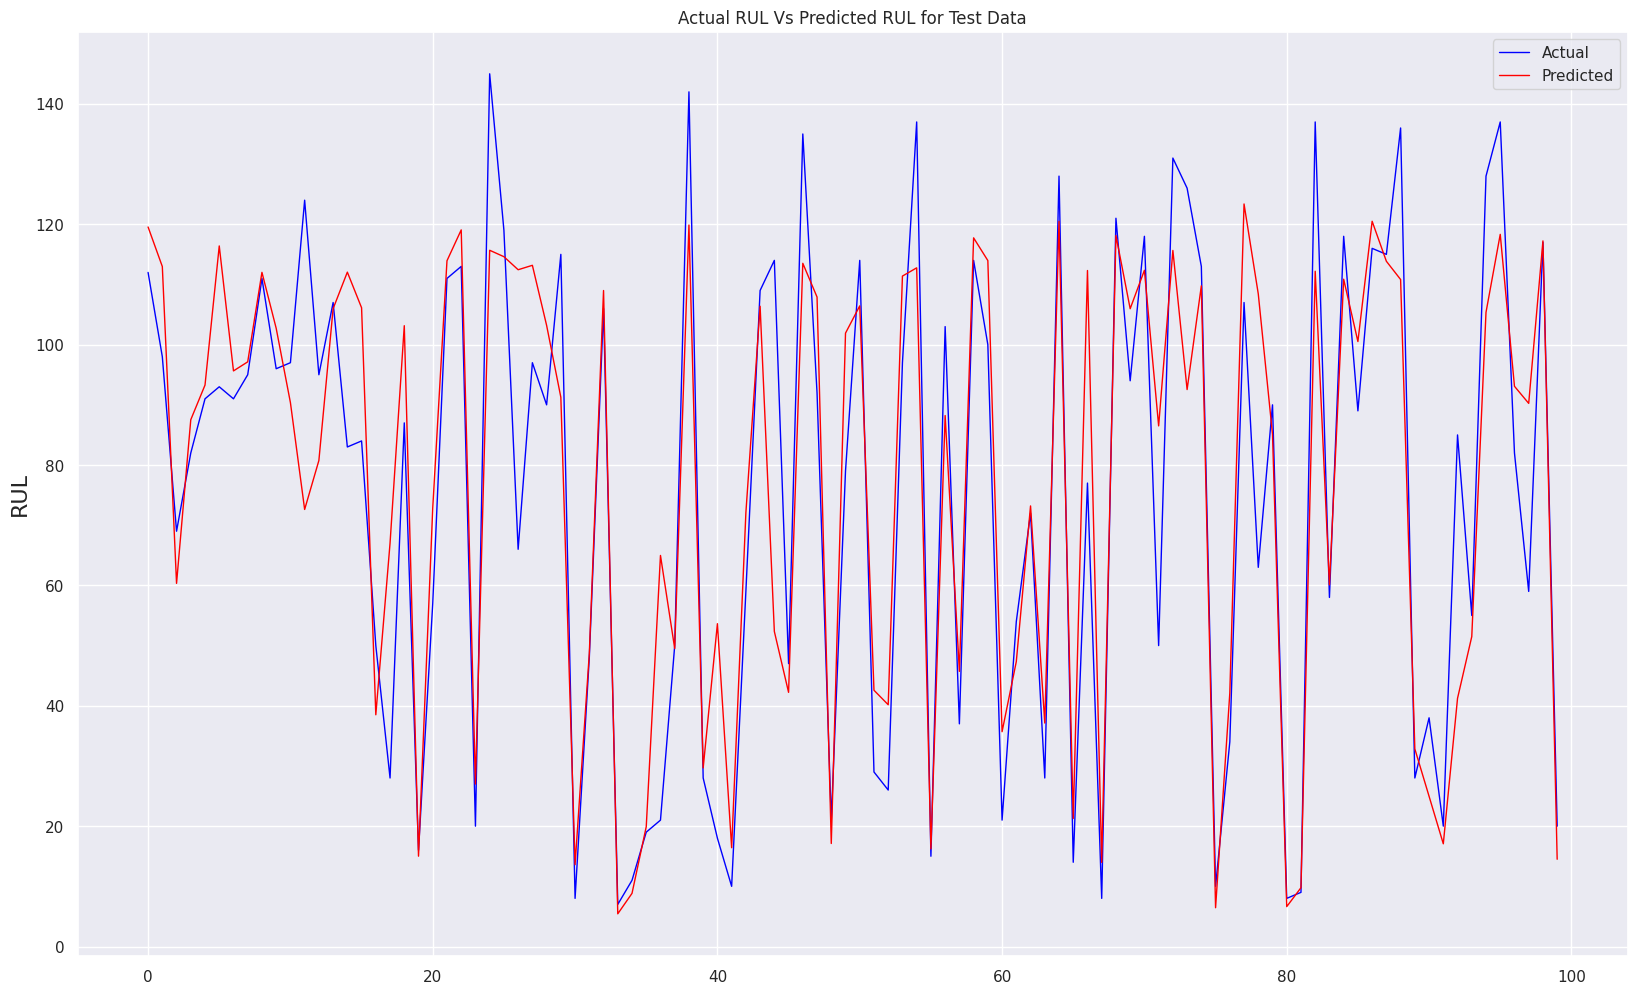

In [113]:
# Plot Actual Vs Predicted RUL for Test Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(RUL_test,color="blue", linewidth=1., linestyle="-",label="Actual")
plt.plot(y_hat_test1.detach().numpy(),color="red",  linewidth=1., linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading
#plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")

1. We have applied different type of ML Models and see how they are performing.
2. Best results we are getting is with XGBoost & RNN Model.
3. Many more feature engineering techniques can be applied subject to having domain knowledge of sensors, machine past history, machine OEM reccomendations etc.


For improving the performance, you may consider to smooth the values for each sensor or split the training set into train/validation sets and select the best model on the validation set, or use a different correlation coefficient threshold.

You may also consider to create more powerful networks or perform an analysis of their hyper-parameters (e.g., hidden size/num layers of RNNs, replace RNNs with LSTMs, etc.).